## Assignment 1:

The dataset and task we chose is the dog breed identification.


## Question 1:

A.    The data has 120 classes (120 dog breeds) ,10222 train sample images and 10357 test sample images

B.     Each data sample image we insert needs to be 224x224 image with 3 RGB channels.so we need to preprocess the data before using it by resizing the images to the wanted size.

D.    No

In [274]:
import numpy as np
import pandas as pd 
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras import optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from random import randint
from time import gmtime, strftime
import matplotlib.pyplot as plt
import PIL
from keras.preprocessing import image


import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


In [2]:
df_train = pd.read_csv('../input/labels.csv')
df_test = pd.read_csv('../input/sample_submission.csv')

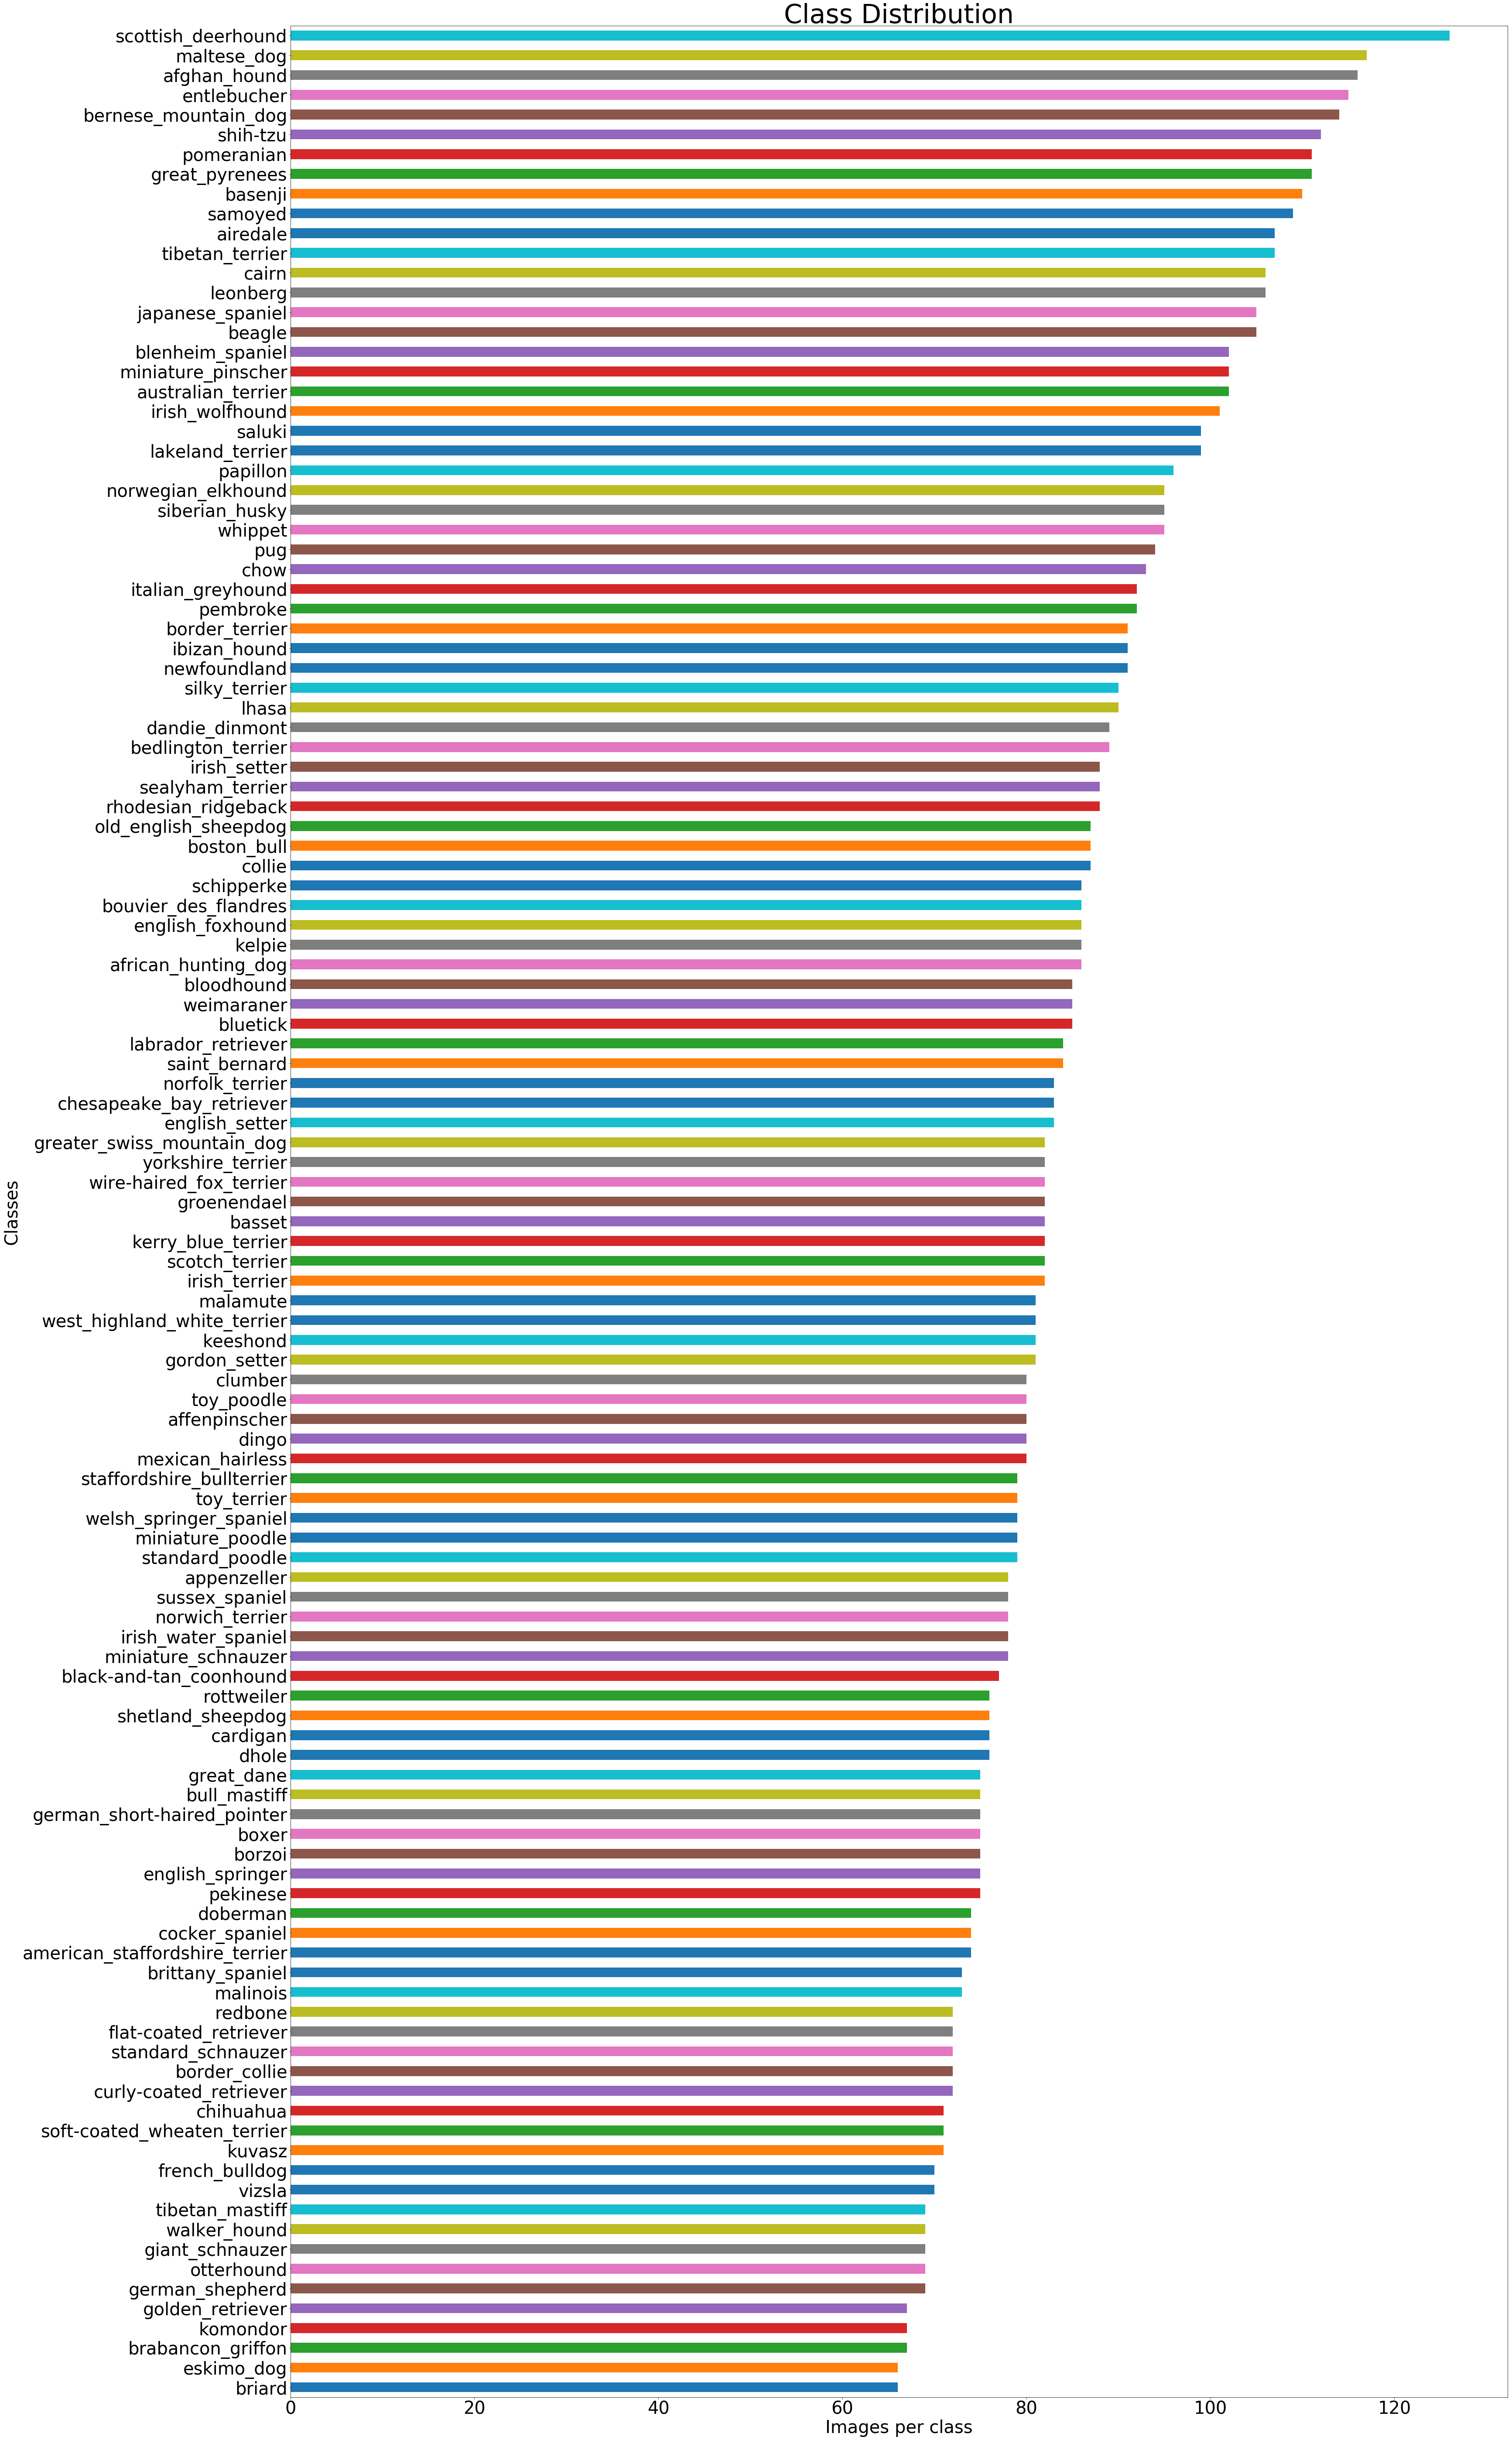

In [3]:
ax=pd.value_counts(df_train['breed'],ascending=True).plot(kind='barh',
                                                       fontsize="40",
                                                       title="Class Distribution",
                                                       figsize=(50,100))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)

C.    Partly balanced, the number of samples per class varied from 60 to 130.


In [182]:
targets_series = pd.Series(df_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)


In [10]:
def read_and_resize_images(df,nrow=224,ncol=224,channels=3):
    i = 0
    x = []
    y = []
    breeds = []
    for f, breed in tqdm(df.values):
        img = PIL.Image.open(os.path.join('../input/train/' + f +'.jpg'))
        label = one_hot_labels[i]
        x.append(img.resize((nrow,ncol)))
        y.append(label)
        breeds.append(breed)
        i += 1
    return x,y,breeds

def read_and_resize_images_test(df,nrow=224,ncol=224,channels=3):
    x = []
    for f in tqdm(df['id'].values):
        img = PIL.Image.open(os.path.join('../input/test/' + f +'.jpg'))
        x.append(img.resize((nrow,ncol)))
    return x

We define the resizing preprocess functions for the train samples and the test samples. Also we convert the images to an array with the dimensions 224x224x3 

In [11]:
x_test = read_and_resize_images_test(df_test)
x_train,y_train,breeds_train = read_and_resize_images(df_train)

100%|██████████| 10222/10222 [00:50<00:00, 202.10it/s]


In [12]:

x_train_raw = []
x_test_raw = []
y_train_raw = np.asarray(y_train) 
for img in x_train:
    x_train_raw.append(np.array(img))
for img in x_test:
    x_test_raw.append(np.array(img))
    
x_train_raw = np.array(x_train_raw)
x_test_raw = np.array(x_test_raw)

In [21]:
print('Training samples {0}'.format(x_train_raw.shape))
print('Training labels {0}'.format(y_train_raw.shape))
print('Testing samples {0}'.format(x_test_raw.shape))

Training samples (10222, 224, 224, 3)
Training labels (10222, 120)
Testing samples (10357, 224, 224, 3)


The data is in the right shape for the model fitting . The train data is 10222 samples of 224x224x3 arrays and with a corresponding breed to each sample. the test data is 10357 samples of the same dimensions.

In [16]:
def plot_images(images, classes):
    assert len(images) == len(classes) == 9
    
    fig, axes = plt.subplots(3, 3,figsize=(60,60),sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
   
    for i, ax in enumerate(axes.flat):
        
        ax.imshow(images[i])    
        xlabel = "Breed: {0}".format(classes[i])
    
        ax.set_xlabel(xlabel)
        ax.xaxis.label.set_size(60)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

Images to show: 9
Classes to show: 9


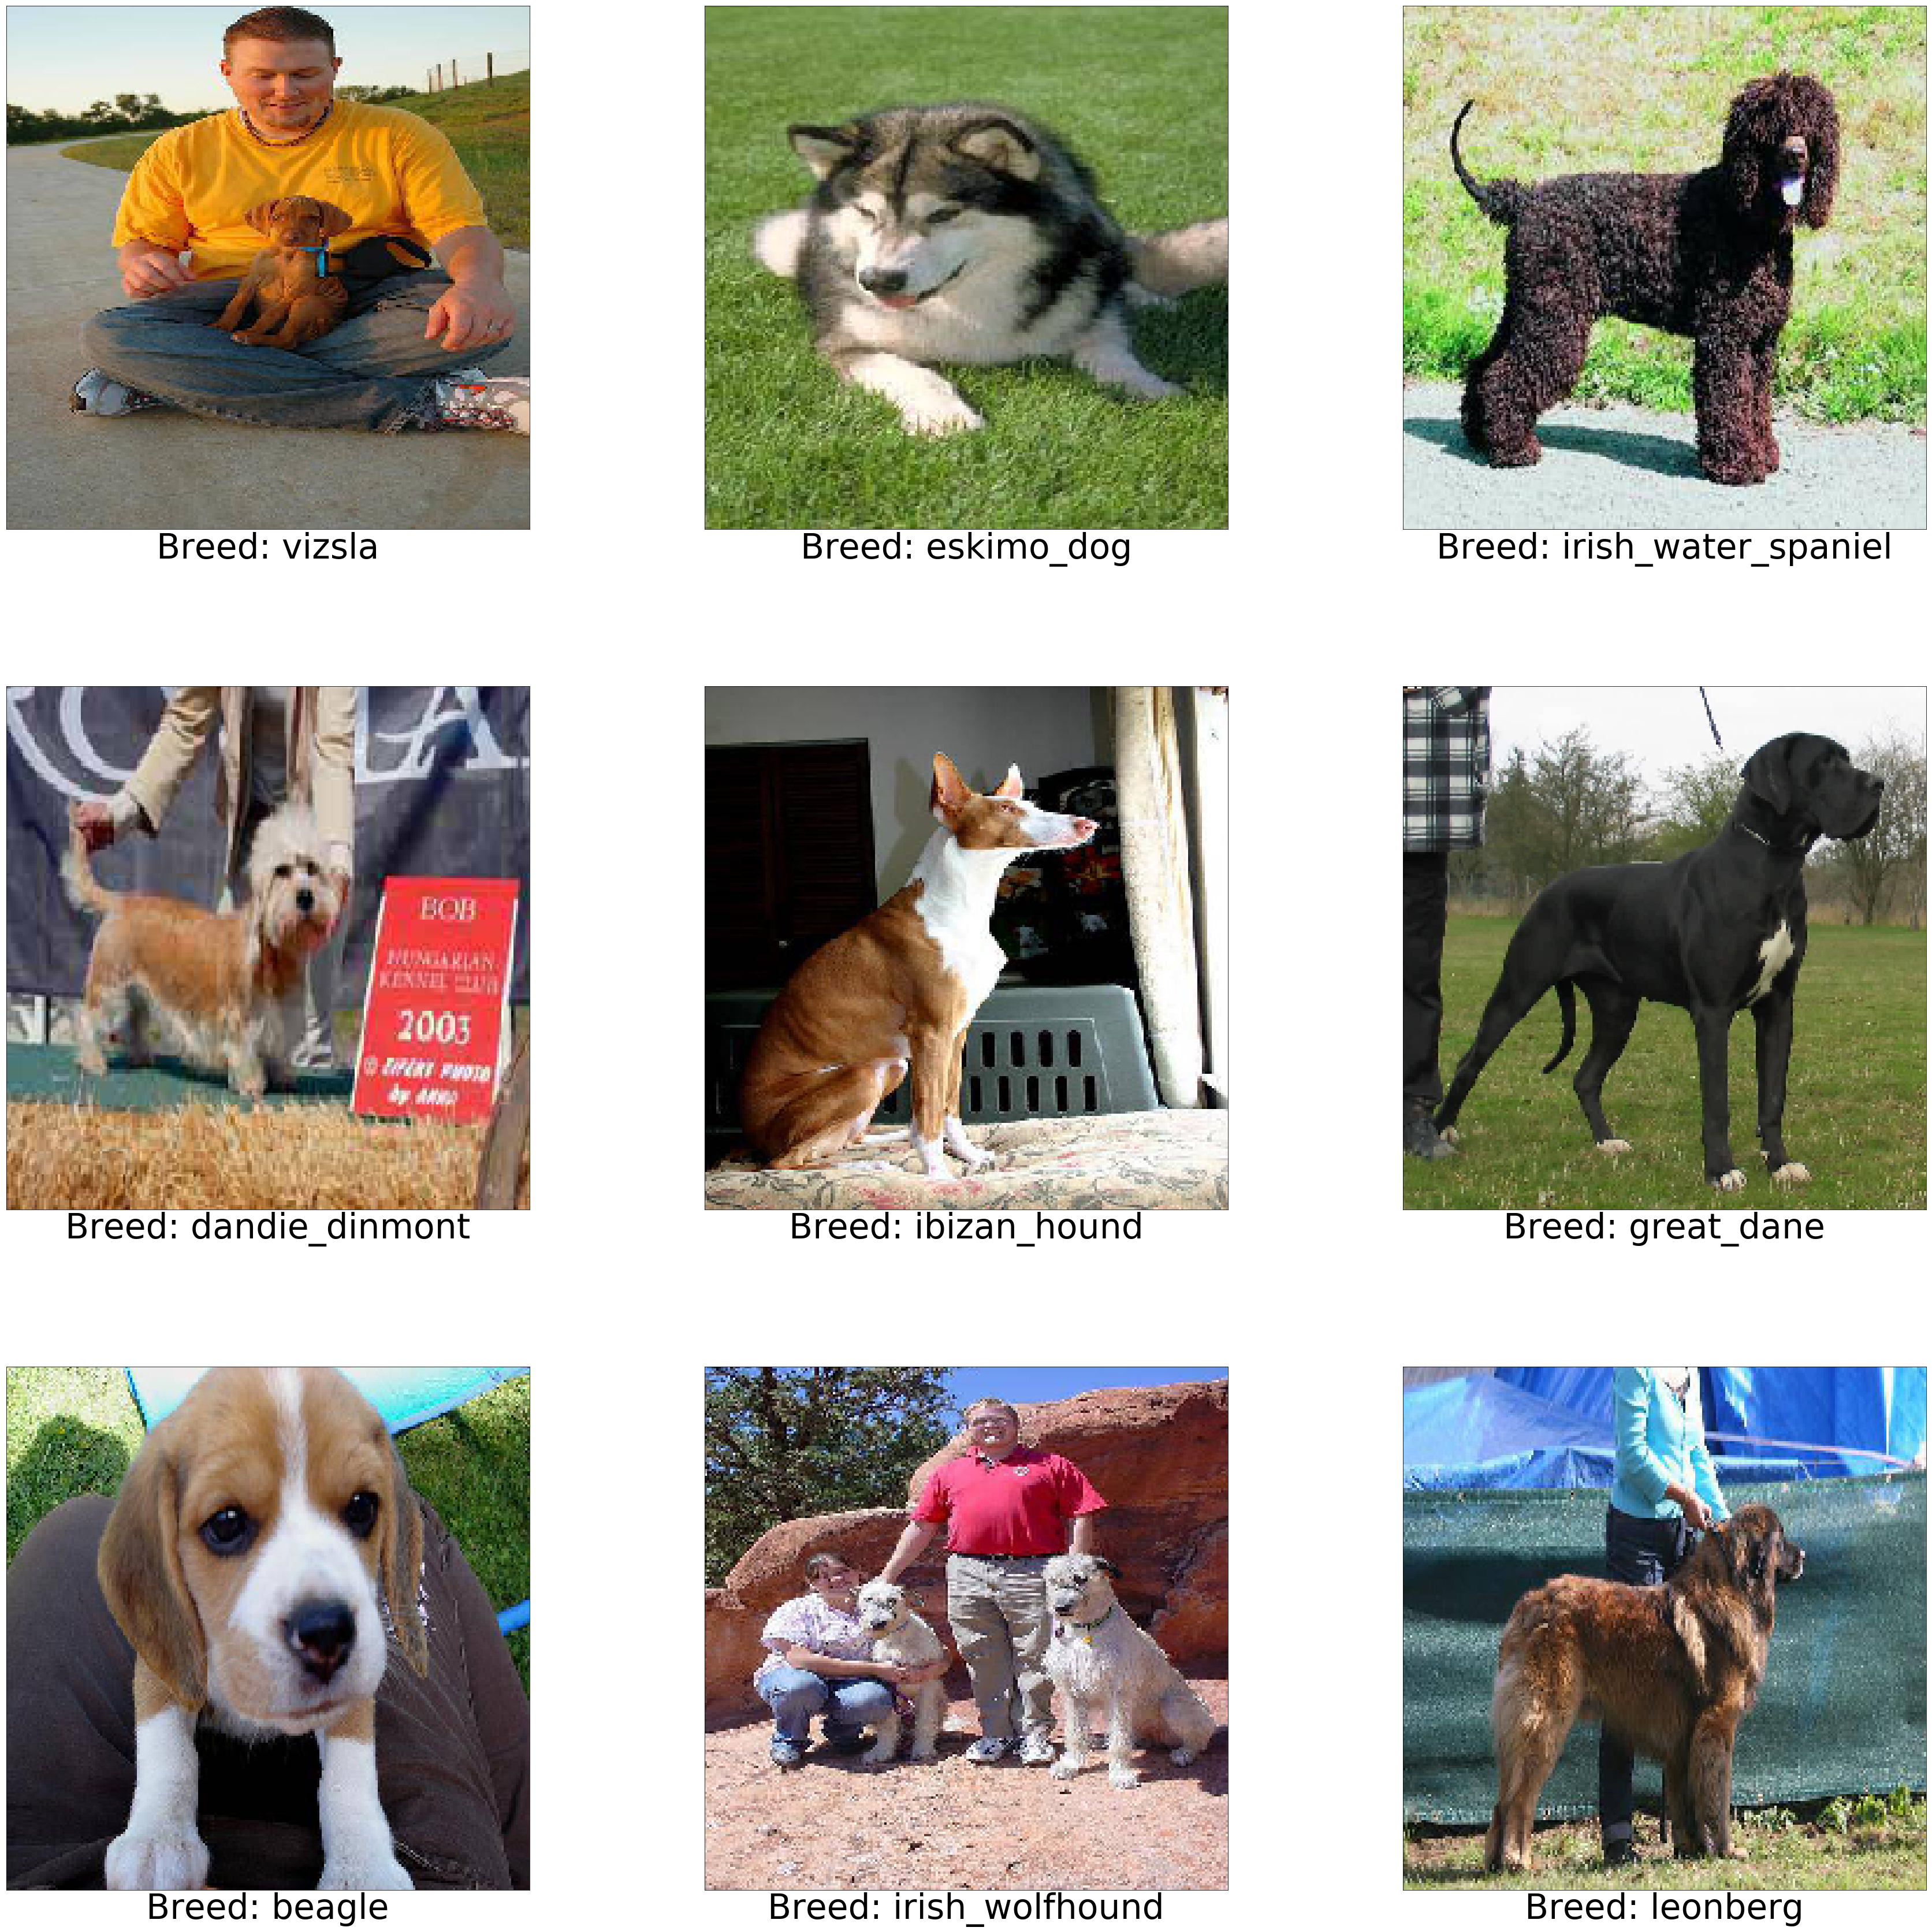

In [17]:

random_numbers = [randint(0, len(x_train)) for p in range(0,9)]
x_train_to_show = [x_train_raw[i] for i in random_numbers]
breeds_train_to_show = [breeds_train[i] for i in random_numbers]
print("Images to show: {0}".format(len(x_train_to_show)))
print("Classes to show: {0}".format(len(breeds_train_to_show)))

plot_images(x_train_to_show, breeds_train_to_show)

## Question 2:

A.   The model we chose is VGG19

Validation:

The training sample is partitioned in order to have validation samples for the fitting. The validation portion of the samples is 15% of the total samples, the samples are chosen randomly from the training samples. 



In [61]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_raw, y_train_raw, test_size=0.15, random_state=1)

In [62]:
print('Training samples {0}'.format(X_train.shape))
print('Training labels {0}'.format(Y_train.shape))
print('Validation samples {0}'.format(X_valid.shape))
print('Validation samples {0}'.format(Y_valid.shape))

Training samples (8688, 224, 224, 3)
Training labels (8688, 120)
Validation samples (1534, 224, 224, 3)
Validation samples (1534, 120)


To enable better feedback and enable better improvements to the module, we shall make some basic callbacks to allow us to monitor the model after each epoch of training. ModelChecker will save the model if it enhances upon the accuarcy of the validation stage of the training. 

The model does not use the pretrained weights of image-net but rather randomized weights. We saw that randomized weights might yield better results as it is a fresh training without the pretrained biases and activity values that are already determined. It is a bit risky as it can produce random results but it might be interesting to see the behaviour of the model with a fresh start.

In [96]:
nowTime = strftime("%m-%d_%H_%M_%S", gmtime())

tb = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
es = EarlyStopping(monitor='val_acc', patience=10, verbose=1)
mc = ModelCheckpoint(f'weights/weights{nowTime}.hdf5'
                             , monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [tb,es,mc]


def prepareModel(num_class):
    base_model = VGG19(#weights='imagenet',
        weights = None, include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)



    model.compile(loss='categorical_crossentropy', 
                  optimizer='sgd', 
                  metrics=['accuracy'])

    return model

In [97]:
firstModel = prepareModel(120)
firstModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [77]:
firstModel.fit(X_train, Y_train,
               epochs=5, validation_data=(X_valid, Y_valid), 
               verbose=0, batch_size=15
              ,callbacks=callbacks_list)

Train on 8688 samples, validate on 1534 samples
Epoch 1/5


3030/8688 [=========>....................] - ETA: 9:40 - loss: 4.8068 - acc: 0.0000e+0 - ETA: 6:00 - loss: 4.8204 - acc: 0.0000e+0 - ETA: 4:46 - loss: 4.8069 - acc: 0.0000e+0 - ETA: 4:08 - loss: 4.8016 - acc: 0.0000e+0 - ETA: 3:46 - loss: 4.7899 - acc: 0.0000e+0 - ETA: 3:31 - loss: 4.7965 - acc: 0.0111    - ETA: 3:20 - loss: 4.7922 - acc: 0.009 - ETA: 3:12 - loss: 4.8055 - acc: 0.008 - ETA: 3:06 - loss: 4.8019 - acc: 0.007 - ETA: 3:00 - loss: 4.8002 - acc: 0.006 - ETA: 2:56 - loss: 4.8041 - acc: 0.006 - ETA: 2:52 - loss: 4.8015 - acc: 0.005 - ETA: 2:49 - loss: 4.7984 - acc: 0.010 - ETA: 2:46 - loss: 4.8029 - acc: 0.009 - ETA: 2:44 - loss: 4.8021 - acc: 0.008 - ETA: 2:42 - loss: 4.8006 - acc: 0.012 - ETA: 2:40 - loss: 4.7988 - acc: 0.011 - ETA: 2:38 - loss: 4.7997 - acc: 0.011 - ETA: 2:37 - loss: 4.8006 - acc: 0.010 - ETA: 2:35 - loss: 4.8007 - acc: 0.010 - ETA: 2:34 - loss: 4.7999 - acc: 0.009 - ETA: 2:33 - loss: 4.8006 - acc: 0.009 - ETA: 2:32 - loss: 4.8007 - acc: 0.008 - ETA: 2:31 -

8688/8688 [==============================] - ETA: 40s - loss: 4.7877 - acc: 0.00 - ETA: 40s - loss: 4.7878 - acc: 0.00 - ETA: 40s - loss: 4.7878 - acc: 0.00 - ETA: 40s - loss: 4.7878 - acc: 0.00 - ETA: 39s - loss: 4.7878 - acc: 0.00 - ETA: 39s - loss: 4.7878 - acc: 0.00 - ETA: 39s - loss: 4.7879 - acc: 0.00 - ETA: 39s - loss: 4.7879 - acc: 0.00 - ETA: 38s - loss: 4.7878 - acc: 0.00 - ETA: 38s - loss: 4.7878 - acc: 0.00 - ETA: 38s - loss: 4.7878 - acc: 0.00 - ETA: 38s - loss: 4.7878 - acc: 0.00 - ETA: 37s - loss: 4.7878 - acc: 0.00 - ETA: 37s - loss: 4.7878 - acc: 0.00 - ETA: 37s - loss: 4.7878 - acc: 0.00 - ETA: 37s - loss: 4.7878 - acc: 0.00 - ETA: 36s - loss: 4.7878 - acc: 0.00 - ETA: 36s - loss: 4.7877 - acc: 0.00 - ETA: 36s - loss: 4.7877 - acc: 0.00 - ETA: 36s - loss: 4.7877 - acc: 0.00 - ETA: 35s - loss: 4.7877 - acc: 0.00 - ETA: 35s - loss: 4.7877 - acc: 0.00 - ETA: 35s - loss: 4.7877 - acc: 0.00 - ETA: 35s - loss: 4.7877 - acc: 0.00 - ETA: 34s - loss: 4.7876 - acc: 0.00 - ETA: 

3060/8688 [=========>....................] - ETA: 2:34 - loss: 4.7459 - acc: 0.0000e+0 - ETA: 2:26 - loss: 4.7783 - acc: 0.0000e+0 - ETA: 2:24 - loss: 4.7653 - acc: 0.0000e+0 - ETA: 2:22 - loss: 4.7391 - acc: 0.0333    - ETA: 2:21 - loss: 4.7401 - acc: 0.026 - ETA: 2:20 - loss: 4.7565 - acc: 0.022 - ETA: 2:20 - loss: 4.7609 - acc: 0.019 - ETA: 2:19 - loss: 4.7710 - acc: 0.016 - ETA: 2:19 - loss: 4.7689 - acc: 0.022 - ETA: 2:18 - loss: 4.7716 - acc: 0.020 - ETA: 2:18 - loss: 4.7695 - acc: 0.018 - ETA: 2:18 - loss: 4.7674 - acc: 0.022 - ETA: 2:17 - loss: 4.7627 - acc: 0.020 - ETA: 2:17 - loss: 4.7657 - acc: 0.023 - ETA: 2:17 - loss: 4.7639 - acc: 0.022 - ETA: 2:16 - loss: 4.7640 - acc: 0.020 - ETA: 2:16 - loss: 4.7639 - acc: 0.019 - ETA: 2:16 - loss: 4.7649 - acc: 0.018 - ETA: 2:16 - loss: 4.7614 - acc: 0.017 - ETA: 2:16 - loss: 4.7663 - acc: 0.016 - ETA: 2:15 - loss: 4.7638 - acc: 0.015 - ETA: 2:15 - loss: 4.7653 - acc: 0.018 - ETA: 2:15 - loss: 4.7660 - acc: 0.017 - ETA: 2:15 - loss: 4

8688/8688 [==============================] - ETA: 40s - loss: 4.7802 - acc: 0.01 - ETA: 40s - loss: 4.7802 - acc: 0.01 - ETA: 39s - loss: 4.7802 - acc: 0.01 - ETA: 39s - loss: 4.7802 - acc: 0.01 - ETA: 39s - loss: 4.7803 - acc: 0.01 - ETA: 39s - loss: 4.7803 - acc: 0.01 - ETA: 38s - loss: 4.7803 - acc: 0.01 - ETA: 38s - loss: 4.7803 - acc: 0.01 - ETA: 38s - loss: 4.7803 - acc: 0.01 - ETA: 38s - loss: 4.7803 - acc: 0.01 - ETA: 37s - loss: 4.7803 - acc: 0.01 - ETA: 37s - loss: 4.7803 - acc: 0.01 - ETA: 37s - loss: 4.7802 - acc: 0.01 - ETA: 37s - loss: 4.7801 - acc: 0.01 - ETA: 36s - loss: 4.7801 - acc: 0.01 - ETA: 36s - loss: 4.7802 - acc: 0.01 - ETA: 36s - loss: 4.7800 - acc: 0.01 - ETA: 36s - loss: 4.7799 - acc: 0.01 - ETA: 35s - loss: 4.7798 - acc: 0.01 - ETA: 35s - loss: 4.7797 - acc: 0.01 - ETA: 35s - loss: 4.7796 - acc: 0.01 - ETA: 35s - loss: 4.7792 - acc: 0.01 - ETA: 35s - loss: 4.7796 - acc: 0.01 - ETA: 34s - loss: 4.7795 - acc: 0.01 - ETA: 34s - loss: 4.7795 - acc: 0.01 - ETA: 

3060/8688 [=========>....................] - ETA: 2:18 - loss: 4.7667 - acc: 0.066 - ETA: 2:18 - loss: 4.7771 - acc: 0.033 - ETA: 2:19 - loss: 4.7756 - acc: 0.022 - ETA: 2:19 - loss: 4.7622 - acc: 0.016 - ETA: 2:18 - loss: 4.7722 - acc: 0.013 - ETA: 2:18 - loss: 4.7706 - acc: 0.022 - ETA: 2:18 - loss: 4.7715 - acc: 0.019 - ETA: 2:18 - loss: 4.7732 - acc: 0.016 - ETA: 2:18 - loss: 4.7686 - acc: 0.014 - ETA: 2:18 - loss: 4.7664 - acc: 0.013 - ETA: 2:17 - loss: 4.7816 - acc: 0.012 - ETA: 2:17 - loss: 4.7775 - acc: 0.016 - ETA: 2:17 - loss: 4.7787 - acc: 0.015 - ETA: 2:17 - loss: 4.7787 - acc: 0.014 - ETA: 2:16 - loss: 4.7787 - acc: 0.013 - ETA: 2:16 - loss: 4.7775 - acc: 0.012 - ETA: 2:16 - loss: 4.7760 - acc: 0.015 - ETA: 2:15 - loss: 4.7813 - acc: 0.014 - ETA: 2:15 - loss: 4.7826 - acc: 0.014 - ETA: 2:15 - loss: 4.7813 - acc: 0.013 - ETA: 2:15 - loss: 4.7832 - acc: 0.012 - ETA: 2:15 - loss: 4.7820 - acc: 0.015 - ETA: 2:14 - loss: 4.7813 - acc: 0.014 - ETA: 2:14 - loss: 4.7808 - acc: 0.0

8688/8688 [==============================] - ETA: 40s - loss: 4.7688 - acc: 0.01 - ETA: 40s - loss: 4.7687 - acc: 0.01 - ETA: 40s - loss: 4.7687 - acc: 0.01 - ETA: 39s - loss: 4.7687 - acc: 0.01 - ETA: 39s - loss: 4.7687 - acc: 0.01 - ETA: 39s - loss: 4.7687 - acc: 0.01 - ETA: 39s - loss: 4.7687 - acc: 0.01 - ETA: 38s - loss: 4.7688 - acc: 0.01 - ETA: 38s - loss: 4.7686 - acc: 0.01 - ETA: 38s - loss: 4.7683 - acc: 0.01 - ETA: 38s - loss: 4.7682 - acc: 0.01 - ETA: 37s - loss: 4.7682 - acc: 0.01 - ETA: 37s - loss: 4.7681 - acc: 0.01 - ETA: 37s - loss: 4.7680 - acc: 0.01 - ETA: 37s - loss: 4.7677 - acc: 0.01 - ETA: 36s - loss: 4.7671 - acc: 0.01 - ETA: 36s - loss: 4.7674 - acc: 0.01 - ETA: 36s - loss: 4.7673 - acc: 0.01 - ETA: 36s - loss: 4.7673 - acc: 0.01 - ETA: 35s - loss: 4.7672 - acc: 0.01 - ETA: 35s - loss: 4.7673 - acc: 0.01 - ETA: 35s - loss: 4.7673 - acc: 0.01 - ETA: 35s - loss: 4.7672 - acc: 0.01 - ETA: 34s - loss: 4.7672 - acc: 0.01 - ETA: 34s - loss: 4.7669 - acc: 0.01 - ETA: 

3060/8688 [=========>....................] - ETA: 2:18 - loss: 4.8059 - acc: 0.066 - ETA: 2:18 - loss: 4.7765 - acc: 0.033 - ETA: 2:18 - loss: 4.7722 - acc: 0.022 - ETA: 2:19 - loss: 4.7387 - acc: 0.033 - ETA: 2:18 - loss: 4.7537 - acc: 0.026 - ETA: 2:18 - loss: 4.7501 - acc: 0.033 - ETA: 2:18 - loss: 4.7567 - acc: 0.028 - ETA: 2:18 - loss: 4.7479 - acc: 0.025 - ETA: 2:17 - loss: 4.7377 - acc: 0.022 - ETA: 2:17 - loss: 4.7166 - acc: 0.020 - ETA: 2:17 - loss: 4.7326 - acc: 0.018 - ETA: 2:17 - loss: 4.7360 - acc: 0.016 - ETA: 2:17 - loss: 4.7378 - acc: 0.015 - ETA: 2:16 - loss: 4.7386 - acc: 0.014 - ETA: 2:16 - loss: 4.7410 - acc: 0.013 - ETA: 2:16 - loss: 4.7418 - acc: 0.016 - ETA: 2:16 - loss: 4.7425 - acc: 0.015 - ETA: 2:15 - loss: 4.7384 - acc: 0.018 - ETA: 2:15 - loss: 4.7366 - acc: 0.017 - ETA: 2:15 - loss: 4.7338 - acc: 0.016 - ETA: 2:15 - loss: 4.7424 - acc: 0.015 - ETA: 2:15 - loss: 4.7418 - acc: 0.015 - ETA: 2:14 - loss: 4.7406 - acc: 0.014 - ETA: 2:14 - loss: 4.7363 - acc: 0.0

8688/8688 [==============================] - ETA: 40s - loss: 4.7673 - acc: 0.01 - ETA: 40s - loss: 4.7674 - acc: 0.01 - ETA: 39s - loss: 4.7674 - acc: 0.01 - ETA: 39s - loss: 4.7674 - acc: 0.01 - ETA: 39s - loss: 4.7674 - acc: 0.01 - ETA: 39s - loss: 4.7674 - acc: 0.01 - ETA: 38s - loss: 4.7675 - acc: 0.01 - ETA: 38s - loss: 4.7675 - acc: 0.01 - ETA: 38s - loss: 4.7675 - acc: 0.01 - ETA: 38s - loss: 4.7676 - acc: 0.01 - ETA: 37s - loss: 4.7676 - acc: 0.01 - ETA: 37s - loss: 4.7676 - acc: 0.01 - ETA: 37s - loss: 4.7676 - acc: 0.01 - ETA: 37s - loss: 4.7676 - acc: 0.01 - ETA: 36s - loss: 4.7677 - acc: 0.01 - ETA: 36s - loss: 4.7677 - acc: 0.01 - ETA: 36s - loss: 4.7677 - acc: 0.01 - ETA: 36s - loss: 4.7677 - acc: 0.01 - ETA: 35s - loss: 4.7677 - acc: 0.01 - ETA: 35s - loss: 4.7677 - acc: 0.01 - ETA: 35s - loss: 4.7677 - acc: 0.01 - ETA: 35s - loss: 4.7677 - acc: 0.01 - ETA: 34s - loss: 4.7677 - acc: 0.01 - ETA: 34s - loss: 4.7675 - acc: 0.01 - ETA: 34s - loss: 4.7675 - acc: 0.01 - ETA: 

3060/8688 [=========>....................] - ETA: 2:18 - loss: 4.8545 - acc: 0.0000e+0 - ETA: 2:19 - loss: 4.7952 - acc: 0.0000e+0 - ETA: 2:19 - loss: 4.7393 - acc: 0.0444    - ETA: 2:19 - loss: 4.7371 - acc: 0.050 - ETA: 2:19 - loss: 4.7255 - acc: 0.053 - ETA: 2:18 - loss: 4.6989 - acc: 0.044 - ETA: 2:18 - loss: 4.7239 - acc: 0.047 - ETA: 2:18 - loss: 4.7289 - acc: 0.050 - ETA: 2:18 - loss: 4.7303 - acc: 0.044 - ETA: 2:18 - loss: 4.7176 - acc: 0.040 - ETA: 2:17 - loss: 4.7166 - acc: 0.036 - ETA: 2:17 - loss: 4.6986 - acc: 0.044 - ETA: 2:17 - loss: 4.6956 - acc: 0.041 - ETA: 2:17 - loss: 4.6851 - acc: 0.038 - ETA: 2:16 - loss: 4.6897 - acc: 0.035 - ETA: 2:16 - loss: 4.6889 - acc: 0.037 - ETA: 2:16 - loss: 4.6872 - acc: 0.035 - ETA: 2:16 - loss: 4.6856 - acc: 0.040 - ETA: 2:15 - loss: 4.6919 - acc: 0.038 - ETA: 2:15 - loss: 4.6933 - acc: 0.036 - ETA: 2:15 - loss: 4.6905 - acc: 0.034 - ETA: 2:15 - loss: 4.6860 - acc: 0.036 - ETA: 2:14 - loss: 4.6911 - acc: 0.034 - ETA: 2:14 - loss: 4.689

8688/8688 [==============================] - ETA: 40s - loss: 4.6680 - acc: 0.02 - ETA: 40s - loss: 4.6673 - acc: 0.02 - ETA: 39s - loss: 4.6671 - acc: 0.02 - ETA: 39s - loss: 4.6672 - acc: 0.02 - ETA: 39s - loss: 4.6670 - acc: 0.02 - ETA: 39s - loss: 4.6662 - acc: 0.02 - ETA: 38s - loss: 4.6654 - acc: 0.02 - ETA: 38s - loss: 4.6655 - acc: 0.02 - ETA: 38s - loss: 4.6647 - acc: 0.02 - ETA: 38s - loss: 4.6647 - acc: 0.02 - ETA: 37s - loss: 4.6644 - acc: 0.02 - ETA: 37s - loss: 4.6641 - acc: 0.02 - ETA: 37s - loss: 4.6635 - acc: 0.02 - ETA: 37s - loss: 4.6631 - acc: 0.02 - ETA: 36s - loss: 4.6628 - acc: 0.02 - ETA: 36s - loss: 4.6626 - acc: 0.02 - ETA: 36s - loss: 4.6625 - acc: 0.02 - ETA: 36s - loss: 4.6623 - acc: 0.02 - ETA: 35s - loss: 4.6618 - acc: 0.02 - ETA: 35s - loss: 4.6621 - acc: 0.02 - ETA: 35s - loss: 4.6619 - acc: 0.02 - ETA: 35s - loss: 4.6614 - acc: 0.02 - ETA: 34s - loss: 4.6614 - acc: 0.02 - ETA: 34s - loss: 4.6612 - acc: 0.02 - ETA: 34s - loss: 4.6607 - acc: 0.02 - ETA: 

In [78]:
preds = firstModel.predict(x_test_raw, verbose=1)

10357/10357 [==============================] - ETA: 4: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ET

After training our model for 5 epochs with batch size of 15. The results are not that good, we only get 2.542% accuarcy during validation 

In [248]:
sub = pd.DataFrame(preds)
col_names = one_hot.columns.values
sub.columns = col_names
sub.insert(0, 'id', df_test['id'])
sub.head(15)

id  affenpinscher  afghan_hound  \
0   000621fb3cbb32d8935728e48679680e       0.000014      0.001979   
1   00102ee9d8eb90812350685311fe5890       0.000045      0.000105   
2   0012a730dfa437f5f3613fb75efcd4ce       0.002106      0.004755   
3   001510bc8570bbeee98c8d80c8a95ec1       0.000801      0.001134   
4   001a5f3114548acdefa3d4da05474c2e       0.000144      0.002360   
5   00225dcd3e4d2410dd53239f95c0352f       0.010289      0.008329   
6   002c2a3117c2193b4d26400ce431eebd       0.000417      0.000376   
7   002c58d413a521ae8d1a5daeb35fc803       0.000001      0.000048   
8   002f80396f1e3db687c5932d7978b196       0.000342      0.000788   
9   0036c6bcec6031be9e62a257b1c3c442       0.001213      0.001092   
10  0041940322116ae58c38130f5a6f71f9       0.014973      0.004393   
11  0042d6bf3e5f3700865886db32689436       0.000010      0.001597   
12  004476c96f575879af4af471af65cae8       0.008077      0.003928   
13  00485d47de966a9437ad3b33ac193b6f       0.000178      0.005331   
14  00496f65de6cc319145ce97bd6e90360       0.000644      0.001182   

    african_hunting_dog  airedale  american_staffordshire_terrier  \
0              0.002924  0.001464                        0.000409   
1              0.000320  0.001333                        0.002909   
2              0.008836  0.001479                        0.005612   
3              0.003684  0.000444                        0.021921   
4              0.001773  0.000184                        0.014250   
5              0.016745  0.001335                        0.002391   
6              0.016085  0.012227                        0.003243   
7              0.000063  0.000018                        0.000281   
8              0.000965  0.001473                        0.004934   
9              0.003561  0.013459                        0.008490   
10             0.010783  0.002406                        0.001370   
11             0.000739  0.000427                        0.003174   
12             0.001984  0.001004                        0.013330   
13             0.002656  0.003052                        0.006109   
14             0.007472  0.001117                        0.003175   

     appenzeller  australian_terrier   basenji    basset        ...          \
0   3.835274e-05            0.000219  0.003235  0.001167        ...           
1   1.869957e-05            0.000081  0.000243  0.001226        ...           
2   3.583308e-03            0.001850  0.004968  0.002380        ...           
3   4.984585e-03            0.003273  0.033090  0.003066        ...           
4   1.259786e-02            0.000140  0.004070  0.003372        ...           
5   7.210039e-04            0.005132  0.002173  0.001487        ...           
6   1.345544e-02            0.000709  0.009462  0.001074        ...           
7   7.343940e-07            0.000152  0.000053  0.000113        ...           
8   2.951427e-03            0.001473  0.018942  0.002750        ...           
9   7.343371e-04            0.006624  0.002966  0.001579        ...           
10  3.107019e-04            0.008809  0.000348  0.000114        ...           
11  4.778333e-05            0.000096  0.004258  0.000041        ...           
12  8.929375e-04            0.000174  0.000272  0.001070        ...           
13  8.619450e-03            0.003739  0.008559  0.000585        ...           
14  4.928809e-05            0.022826  0.001115  0.000255        ...           

    toy_poodle  toy_terrier        vizsla  walker_hound  weimaraner  \
0     0.001809     0.000954  2.669828e-03      0.006310    0.000565   
1     0.014484     0.006335  1.327423e-04      0.000501    0.002095   
2     0.010357     0.034584  5.689595e-04      0.002041    0.008827   
3     0.003847     0.000606  7.363548e-04      0.001208    0.005015   
4     0.003266     0.011890  3.323217e-04      0.002345    0.004095   
5     0.002115     0.001720  6.675427e-04      0.001981    0.014825   
6     0.000815     0.000172  1.800765e-02      0.000395    0.0

In [217]:
def bestPreds(model, imgstr, top):
    example = df_train[df_train['id'] == imgstr]
    im = PIL.Image.open('../input/train/{0}'.format(imgstr) + '.jpg').resize((224,224))
    im = np.array(im)
    plt.imshow(im)
    plt.xlabel(example.breed)
    plt.show()
    im = np.expand_dims(im, axis=0)
    print('input shape: {0}'.format(im.shape))
    result = model.predict(im, verbose=1)
    sortedres = (-result).argsort()[0][:top]
    print('The best matches:')
    for index in sortedres:
        print('breed {0}'.format(one_hot.columns[index]))
        print('\t with accuarcy: {0}'.format(result[0][index]))

From the small batch we see here, we cant distuingish with certainty the breed of each sample, every value is to small to assume with confidence that this is the right breed. Here are examples of some samples.

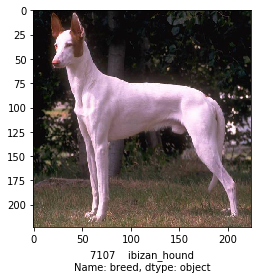

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 65ms/step
The best matches:
breed otterhound
	 with accuarcy: 0.011563155800104141
breed basenji
	 with accuarcy: 0.011358522810041904
breed irish_water_spaniel
	 with accuarcy: 0.011079682037234306
breed wire-haired_fox_terrier
	 with accuarcy: 0.010896437801420689
breed mexican_hairless
	 with accuarcy: 0.010837963782250881


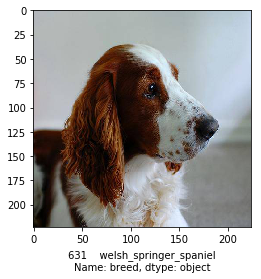

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 28ms/step
The best matches:
breed wire-haired_fox_terrier
	 with accuarcy: 0.011909588240087032
breed irish_water_spaniel
	 with accuarcy: 0.011659642681479454
breed mexican_hairless
	 with accuarcy: 0.0116324657574296
breed otterhound
	 with accuarcy: 0.011580741964280605
breed entlebucher
	 with accuarcy: 0.011071269400417805


In [218]:
bestPreds(firstModel, 'b25f133c4dffc6d1eba2ae381ecb6d18', 5)
bestPreds(firstModel, '0f7c817dd5f8b8d6b57e3b7f3e2f4f56', 5)

As we can see the model is not very accurate in matching the breed to these 2 samples. Lets train the model more with a larger batch size and more epochs. The main reason is to see if the model yields improvements over its run, maybe it becomes overfitted rather quickly.

In [221]:
firstModel.fit(X_train, Y_train,
               epochs=10, validation_data=(X_valid, Y_valid), 
               verbose=1, batch_size=25
              ,callbacks=callbacks_list)

Train on 8688 samples, validate on 1534 samples
Epoch 1/10


5050/8688 [================>.............] - ETA: 2:44 - loss: 4.7944 - acc: 0.0000e+0 - ETA: 3:05 - loss: 4.7984 - acc: 0.0000e+0 - ETA: 2:52 - loss: 4.7943 - acc: 0.0133    - ETA: 2:44 - loss: 4.7966 - acc: 0.010 - ETA: 2:41 - loss: 4.7864 - acc: 0.008 - ETA: 2:37 - loss: 4.7882 - acc: 0.006 - ETA: 2:34 - loss: 4.7958 - acc: 0.005 - ETA: 2:35 - loss: 4.7943 - acc: 0.005 - ETA: 2:33 - loss: 4.7936 - acc: 0.004 - ETA: 2:31 - loss: 4.7952 - acc: 0.008 - ETA: 2:31 - loss: 4.7939 - acc: 0.007 - ETA: 2:30 - loss: 4.7921 - acc: 0.006 - ETA: 2:28 - loss: 4.7914 - acc: 0.006 - ETA: 2:27 - loss: 4.7918 - acc: 0.005 - ETA: 2:27 - loss: 4.7913 - acc: 0.010 - ETA: 2:26 - loss: 4.7915 - acc: 0.010 - ETA: 2:24 - loss: 4.7914 - acc: 0.009 - ETA: 2:24 - loss: 4.7910 - acc: 0.008 - ETA: 2:24 - loss: 4.7914 - acc: 0.008 - ETA: 2:25 - loss: 4.7914 - acc: 0.010 - ETA: 2:24 - loss: 4.7910 - acc: 0.009 - ETA: 2:24 - loss: 4.7888 - acc: 0.010 - ETA: 2:23 - loss: 4.7884 - acc: 0.010 - ETA: 2:22 - loss: 4.789

5100/8688 [================>.............] - ETA: 2:43 - loss: 4.7365 - acc: 0.040 - ETA: 2:35 - loss: 4.7731 - acc: 0.020 - ETA: 2:29 - loss: 4.7670 - acc: 0.013 - ETA: 2:26 - loss: 4.7721 - acc: 0.010 - ETA: 2:24 - loss: 4.7784 - acc: 0.016 - ETA: 2:23 - loss: 4.7788 - acc: 0.020 - ETA: 2:21 - loss: 4.7726 - acc: 0.022 - ETA: 2:20 - loss: 4.7769 - acc: 0.020 - ETA: 2:20 - loss: 4.7741 - acc: 0.017 - ETA: 2:19 - loss: 4.7734 - acc: 0.016 - ETA: 2:18 - loss: 4.7757 - acc: 0.018 - ETA: 2:17 - loss: 4.7743 - acc: 0.020 - ETA: 2:17 - loss: 4.7721 - acc: 0.018 - ETA: 2:16 - loss: 4.7750 - acc: 0.017 - ETA: 2:16 - loss: 4.7752 - acc: 0.016 - ETA: 2:15 - loss: 4.7767 - acc: 0.015 - ETA: 2:15 - loss: 4.7777 - acc: 0.014 - ETA: 2:14 - loss: 4.7788 - acc: 0.013 - ETA: 2:14 - loss: 4.7798 - acc: 0.012 - ETA: 2:13 - loss: 4.7797 - acc: 0.014 - ETA: 2:13 - loss: 4.7794 - acc: 0.013 - ETA: 2:12 - loss: 4.7808 - acc: 0.012 - ETA: 2:12 - loss: 4.7804 - acc: 0.013 - ETA: 2:11 - loss: 4.7813 - acc: 0.0

8688/8688 [==============================] - ETA: 57s - loss: 4.7753 - acc: 0.01 - ETA: 57s - loss: 4.7752 - acc: 0.01 - ETA: 56s - loss: 4.7752 - acc: 0.01 - ETA: 56s - loss: 4.7752 - acc: 0.01 - ETA: 55s - loss: 4.7751 - acc: 0.01 - ETA: 55s - loss: 4.7753 - acc: 0.01 - ETA: 55s - loss: 4.7755 - acc: 0.01 - ETA: 54s - loss: 4.7755 - acc: 0.01 - ETA: 54s - loss: 4.7755 - acc: 0.01 - ETA: 53s - loss: 4.7756 - acc: 0.01 - ETA: 53s - loss: 4.7755 - acc: 0.01 - ETA: 53s - loss: 4.7756 - acc: 0.01 - ETA: 52s - loss: 4.7757 - acc: 0.01 - ETA: 52s - loss: 4.7757 - acc: 0.01 - ETA: 51s - loss: 4.7757 - acc: 0.01 - ETA: 51s - loss: 4.7758 - acc: 0.01 - ETA: 51s - loss: 4.7755 - acc: 0.01 - ETA: 50s - loss: 4.7755 - acc: 0.01 - ETA: 50s - loss: 4.7756 - acc: 0.01 - ETA: 49s - loss: 4.7754 - acc: 0.01 - ETA: 49s - loss: 4.7754 - acc: 0.01 - ETA: 49s - loss: 4.7751 - acc: 0.01 - ETA: 48s - loss: 4.7748 - acc: 0.01 - ETA: 48s - loss: 4.7749 - acc: 0.01 - ETA: 47s - loss: 4.7746 - acc: 0.01 - ETA: 

5100/8688 [================>.............] - ETA: 2:18 - loss: 4.7441 - acc: 0.0000e+0 - ETA: 2:19 - loss: 4.7402 - acc: 0.0200    - ETA: 2:19 - loss: 4.7306 - acc: 0.013 - ETA: 2:19 - loss: 4.7402 - acc: 0.020 - ETA: 2:18 - loss: 4.7234 - acc: 0.016 - ETA: 2:18 - loss: 4.7418 - acc: 0.013 - ETA: 2:17 - loss: 4.7345 - acc: 0.022 - ETA: 2:17 - loss: 4.7358 - acc: 0.025 - ETA: 2:17 - loss: 4.7300 - acc: 0.022 - ETA: 2:17 - loss: 4.7336 - acc: 0.024 - ETA: 2:16 - loss: 4.7324 - acc: 0.021 - ETA: 2:16 - loss: 4.7277 - acc: 0.030 - ETA: 2:15 - loss: 4.7392 - acc: 0.030 - ETA: 2:15 - loss: 4.7431 - acc: 0.028 - ETA: 2:14 - loss: 4.7414 - acc: 0.026 - ETA: 2:13 - loss: 4.7401 - acc: 0.025 - ETA: 2:13 - loss: 4.7401 - acc: 0.023 - ETA: 2:12 - loss: 4.7369 - acc: 0.022 - ETA: 2:12 - loss: 4.7397 - acc: 0.021 - ETA: 2:12 - loss: 4.7371 - acc: 0.022 - ETA: 2:11 - loss: 4.7364 - acc: 0.022 - ETA: 2:11 - loss: 4.7350 - acc: 0.023 - ETA: 2:10 - loss: 4.7366 - acc: 0.022 - ETA: 2:10 - loss: 4.7336 - 

5100/8688 [================>.............] - ETA: 2:16 - loss: 4.6482 - acc: 0.0000e+0 - ETA: 2:16 - loss: 4.6748 - acc: 0.0000e+0 - ETA: 2:16 - loss: 4.6588 - acc: 0.0133    - ETA: 2:15 - loss: 4.6358 - acc: 0.010 - ETA: 2:15 - loss: 4.6479 - acc: 0.016 - ETA: 2:14 - loss: 4.6606 - acc: 0.013 - ETA: 2:14 - loss: 4.6558 - acc: 0.011 - ETA: 2:14 - loss: 4.6689 - acc: 0.010 - ETA: 2:13 - loss: 4.6626 - acc: 0.017 - ETA: 2:13 - loss: 4.6459 - acc: 0.020 - ETA: 2:12 - loss: 4.6757 - acc: 0.018 - ETA: 2:12 - loss: 4.6809 - acc: 0.016 - ETA: 2:11 - loss: 4.6850 - acc: 0.015 - ETA: 2:11 - loss: 4.6868 - acc: 0.014 - ETA: 2:11 - loss: 4.6897 - acc: 0.016 - ETA: 2:10 - loss: 4.6865 - acc: 0.015 - ETA: 2:10 - loss: 4.6882 - acc: 0.014 - ETA: 2:10 - loss: 4.6928 - acc: 0.013 - ETA: 2:09 - loss: 4.6930 - acc: 0.012 - ETA: 2:09 - loss: 4.6885 - acc: 0.012 - ETA: 2:09 - loss: 4.6878 - acc: 0.013 - ETA: 2:08 - loss: 4.6777 - acc: 0.014 - ETA: 2:08 - loss: 4.6724 - acc: 0.013 - ETA: 2:08 - loss: 4.674

8688/8688 [==============================] - ETA: 56s - loss: 4.7299 - acc: 0.01 - ETA: 55s - loss: 4.7301 - acc: 0.01 - ETA: 55s - loss: 4.7298 - acc: 0.01 - ETA: 54s - loss: 4.7298 - acc: 0.01 - ETA: 54s - loss: 4.7297 - acc: 0.01 - ETA: 54s - loss: 4.7292 - acc: 0.01 - ETA: 53s - loss: 4.7301 - acc: 0.01 - ETA: 53s - loss: 4.7302 - acc: 0.01 - ETA: 52s - loss: 4.7305 - acc: 0.01 - ETA: 52s - loss: 4.7308 - acc: 0.01 - ETA: 52s - loss: 4.7309 - acc: 0.01 - ETA: 51s - loss: 4.7311 - acc: 0.01 - ETA: 51s - loss: 4.7312 - acc: 0.01 - ETA: 50s - loss: 4.7315 - acc: 0.01 - ETA: 50s - loss: 4.7318 - acc: 0.01 - ETA: 50s - loss: 4.7320 - acc: 0.01 - ETA: 49s - loss: 4.7320 - acc: 0.01 - ETA: 49s - loss: 4.7322 - acc: 0.01 - ETA: 48s - loss: 4.7323 - acc: 0.01 - ETA: 48s - loss: 4.7324 - acc: 0.01 - ETA: 48s - loss: 4.7326 - acc: 0.01 - ETA: 47s - loss: 4.7325 - acc: 0.01 - ETA: 47s - loss: 4.7327 - acc: 0.01 - ETA: 47s - loss: 4.7327 - acc: 0.01 - ETA: 46s - loss: 4.7328 - acc: 0.01 - ETA: 

5125/8688 [================>.............] - ETA: 2:15 - loss: 4.5604 - acc: 0.040 - ETA: 2:15 - loss: 4.6457 - acc: 0.040 - ETA: 2:15 - loss: 4.5899 - acc: 0.053 - ETA: 2:14 - loss: 4.5633 - acc: 0.070 - ETA: 2:14 - loss: 4.6075 - acc: 0.064 - ETA: 2:13 - loss: 4.6244 - acc: 0.060 - ETA: 2:13 - loss: 4.6275 - acc: 0.057 - ETA: 2:12 - loss: 4.6337 - acc: 0.055 - ETA: 2:12 - loss: 4.6243 - acc: 0.053 - ETA: 2:12 - loss: 4.6066 - acc: 0.052 - ETA: 2:11 - loss: 4.5950 - acc: 0.047 - ETA: 2:11 - loss: 4.5948 - acc: 0.046 - ETA: 2:11 - loss: 4.5920 - acc: 0.043 - ETA: 2:10 - loss: 4.5866 - acc: 0.040 - ETA: 2:10 - loss: 4.5783 - acc: 0.037 - ETA: 2:10 - loss: 4.5754 - acc: 0.037 - ETA: 2:09 - loss: 4.5717 - acc: 0.040 - ETA: 2:09 - loss: 4.5921 - acc: 0.037 - ETA: 2:08 - loss: 4.5954 - acc: 0.035 - ETA: 2:08 - loss: 4.6028 - acc: 0.034 - ETA: 2:08 - loss: 4.6072 - acc: 0.034 - ETA: 2:07 - loss: 4.6125 - acc: 0.034 - ETA: 2:07 - loss: 4.6129 - acc: 0.034 - ETA: 2:06 - loss: 4.6148 - acc: 0.0

5125/8688 [================>.............] - ETA: 2:14 - loss: 4.4027 - acc: 0.080 - ETA: 2:14 - loss: 4.3636 - acc: 0.060 - ETA: 2:14 - loss: 4.3644 - acc: 0.040 - ETA: 2:14 - loss: 4.3593 - acc: 0.030 - ETA: 2:13 - loss: 4.4038 - acc: 0.024 - ETA: 2:13 - loss: 4.3853 - acc: 0.026 - ETA: 2:13 - loss: 4.4429 - acc: 0.022 - ETA: 2:12 - loss: 4.4445 - acc: 0.020 - ETA: 2:12 - loss: 4.4399 - acc: 0.031 - ETA: 2:11 - loss: 4.4362 - acc: 0.044 - ETA: 2:11 - loss: 4.4390 - acc: 0.050 - ETA: 2:11 - loss: 4.4351 - acc: 0.053 - ETA: 2:10 - loss: 4.4161 - acc: 0.049 - ETA: 2:10 - loss: 4.4213 - acc: 0.051 - ETA: 2:10 - loss: 4.4310 - acc: 0.053 - ETA: 2:10 - loss: 4.4305 - acc: 0.050 - ETA: 2:09 - loss: 4.4320 - acc: 0.047 - ETA: 2:09 - loss: 4.4357 - acc: 0.046 - ETA: 2:09 - loss: 4.4264 - acc: 0.050 - ETA: 2:09 - loss: 4.4242 - acc: 0.050 - ETA: 2:08 - loss: 4.4182 - acc: 0.049 - ETA: 2:08 - loss: 4.4378 - acc: 0.049 - ETA: 2:07 - loss: 4.4400 - acc: 0.048 - ETA: 2:07 - loss: 4.4389 - acc: 0.0

8688/8688 [==============================] - ETA: 55s - loss: 4.4485 - acc: 0.04 - ETA: 55s - loss: 4.4472 - acc: 0.04 - ETA: 55s - loss: 4.4466 - acc: 0.04 - ETA: 54s - loss: 4.4472 - acc: 0.04 - ETA: 54s - loss: 4.4465 - acc: 0.04 - ETA: 53s - loss: 4.4461 - acc: 0.04 - ETA: 53s - loss: 4.4436 - acc: 0.04 - ETA: 53s - loss: 4.4425 - acc: 0.04 - ETA: 52s - loss: 4.4419 - acc: 0.04 - ETA: 52s - loss: 4.4414 - acc: 0.04 - ETA: 51s - loss: 4.4414 - acc: 0.04 - ETA: 51s - loss: 4.4422 - acc: 0.04 - ETA: 51s - loss: 4.4414 - acc: 0.04 - ETA: 50s - loss: 4.4412 - acc: 0.04 - ETA: 50s - loss: 4.4412 - acc: 0.04 - ETA: 49s - loss: 4.4413 - acc: 0.04 - ETA: 49s - loss: 4.4411 - acc: 0.04 - ETA: 49s - loss: 4.4407 - acc: 0.04 - ETA: 48s - loss: 4.4404 - acc: 0.04 - ETA: 48s - loss: 4.4397 - acc: 0.04 - ETA: 47s - loss: 4.4405 - acc: 0.04 - ETA: 47s - loss: 4.4399 - acc: 0.04 - ETA: 47s - loss: 4.4407 - acc: 0.04 - ETA: 46s - loss: 4.4407 - acc: 0.04 - ETA: 46s - loss: 4.4407 - acc: 0.04 - ETA: 

5125/8688 [================>.............] - ETA: 2:14 - loss: 4.3185 - acc: 0.040 - ETA: 2:15 - loss: 4.2607 - acc: 0.040 - ETA: 2:15 - loss: 4.3607 - acc: 0.040 - ETA: 2:14 - loss: 4.4129 - acc: 0.030 - ETA: 2:14 - loss: 4.4245 - acc: 0.024 - ETA: 2:13 - loss: 4.3709 - acc: 0.040 - ETA: 2:13 - loss: 4.4011 - acc: 0.040 - ETA: 2:12 - loss: 4.3936 - acc: 0.040 - ETA: 2:12 - loss: 4.3746 - acc: 0.044 - ETA: 2:12 - loss: 4.3364 - acc: 0.056 - ETA: 2:12 - loss: 4.3235 - acc: 0.054 - ETA: 2:11 - loss: 4.2802 - acc: 0.063 - ETA: 2:11 - loss: 4.2657 - acc: 0.067 - ETA: 2:11 - loss: 4.2559 - acc: 0.068 - ETA: 2:10 - loss: 4.2606 - acc: 0.066 - ETA: 2:10 - loss: 4.2739 - acc: 0.067 - ETA: 2:10 - loss: 4.2910 - acc: 0.063 - ETA: 2:10 - loss: 4.2852 - acc: 0.064 - ETA: 2:09 - loss: 4.2731 - acc: 0.067 - ETA: 2:09 - loss: 4.2637 - acc: 0.070 - ETA: 2:08 - loss: 4.2782 - acc: 0.066 - ETA: 2:08 - loss: 4.2800 - acc: 0.070 - ETA: 2:08 - loss: 4.2909 - acc: 0.067 - ETA: 2:07 - loss: 4.2898 - acc: 0.0

5125/8688 [================>.............] - ETA: 2:15 - loss: 3.9496 - acc: 0.200 - ETA: 2:15 - loss: 3.8765 - acc: 0.140 - ETA: 2:15 - loss: 3.9579 - acc: 0.133 - ETA: 2:15 - loss: 4.0641 - acc: 0.100 - ETA: 2:14 - loss: 4.0747 - acc: 0.104 - ETA: 2:14 - loss: 4.1296 - acc: 0.100 - ETA: 2:14 - loss: 4.1331 - acc: 0.091 - ETA: 2:13 - loss: 4.1038 - acc: 0.085 - ETA: 2:13 - loss: 4.0850 - acc: 0.084 - ETA: 2:12 - loss: 4.0730 - acc: 0.084 - ETA: 2:12 - loss: 4.0747 - acc: 0.080 - ETA: 2:12 - loss: 4.0880 - acc: 0.080 - ETA: 2:11 - loss: 4.0915 - acc: 0.086 - ETA: 2:11 - loss: 4.0838 - acc: 0.091 - ETA: 2:10 - loss: 4.0947 - acc: 0.093 - ETA: 2:10 - loss: 4.0873 - acc: 0.090 - ETA: 2:10 - loss: 4.0733 - acc: 0.089 - ETA: 2:09 - loss: 4.0868 - acc: 0.086 - ETA: 2:09 - loss: 4.0913 - acc: 0.084 - ETA: 2:08 - loss: 4.0964 - acc: 0.084 - ETA: 2:08 - loss: 4.0952 - acc: 0.083 - ETA: 2:08 - loss: 4.0774 - acc: 0.087 - ETA: 2:07 - loss: 4.0897 - acc: 0.085 - ETA: 2:07 - loss: 4.0990 - acc: 0.0

8688/8688 [==============================] - ETA: 56s - loss: 4.1695 - acc: 0.08 - ETA: 55s - loss: 4.1714 - acc: 0.08 - ETA: 55s - loss: 4.1726 - acc: 0.08 - ETA: 54s - loss: 4.1741 - acc: 0.08 - ETA: 54s - loss: 4.1747 - acc: 0.08 - ETA: 54s - loss: 4.1756 - acc: 0.08 - ETA: 53s - loss: 4.1758 - acc: 0.08 - ETA: 53s - loss: 4.1767 - acc: 0.08 - ETA: 52s - loss: 4.1772 - acc: 0.08 - ETA: 52s - loss: 4.1781 - acc: 0.08 - ETA: 52s - loss: 4.1782 - acc: 0.08 - ETA: 51s - loss: 4.1776 - acc: 0.08 - ETA: 51s - loss: 4.1782 - acc: 0.08 - ETA: 50s - loss: 4.1786 - acc: 0.08 - ETA: 50s - loss: 4.1781 - acc: 0.08 - ETA: 50s - loss: 4.1753 - acc: 0.08 - ETA: 49s - loss: 4.1760 - acc: 0.07 - ETA: 49s - loss: 4.1792 - acc: 0.07 - ETA: 48s - loss: 4.1792 - acc: 0.08 - ETA: 48s - loss: 4.1791 - acc: 0.08 - ETA: 48s - loss: 4.1791 - acc: 0.07 - ETA: 47s - loss: 4.1789 - acc: 0.07 - ETA: 47s - loss: 4.1793 - acc: 0.07 - ETA: 46s - loss: 4.1786 - acc: 0.07 - ETA: 46s - loss: 4.1795 - acc: 0.08 - ETA: 

5125/8688 [================>.............] - ETA: 2:14 - loss: 3.9878 - acc: 0.040 - ETA: 2:14 - loss: 4.0621 - acc: 0.040 - ETA: 2:14 - loss: 4.0737 - acc: 0.066 - ETA: 2:14 - loss: 3.9751 - acc: 0.090 - ETA: 2:14 - loss: 4.0928 - acc: 0.080 - ETA: 2:13 - loss: 4.1262 - acc: 0.073 - ETA: 2:13 - loss: 4.1132 - acc: 0.074 - ETA: 2:13 - loss: 4.0727 - acc: 0.075 - ETA: 2:12 - loss: 4.0099 - acc: 0.084 - ETA: 2:12 - loss: 3.9913 - acc: 0.084 - ETA: 2:11 - loss: 3.9219 - acc: 0.094 - ETA: 2:11 - loss: 3.8912 - acc: 0.096 - ETA: 2:11 - loss: 3.8826 - acc: 0.098 - ETA: 2:10 - loss: 3.8897 - acc: 0.100 - ETA: 2:10 - loss: 3.9037 - acc: 0.096 - ETA: 2:10 - loss: 3.9190 - acc: 0.097 - ETA: 2:10 - loss: 3.9479 - acc: 0.096 - ETA: 2:09 - loss: 3.9508 - acc: 0.097 - ETA: 2:09 - loss: 3.9317 - acc: 0.103 - ETA: 2:08 - loss: 3.9152 - acc: 0.112 - ETA: 2:08 - loss: 3.8979 - acc: 0.120 - ETA: 2:08 - loss: 3.8842 - acc: 0.121 - ETA: 2:07 - loss: 3.8715 - acc: 0.128 - ETA: 2:07 - loss: 3.8984 - acc: 0.1

5125/8688 [================>.............] - ETA: 2:15 - loss: 3.7118 - acc: 0.080 - ETA: 2:15 - loss: 3.8761 - acc: 0.060 - ETA: 2:16 - loss: 3.6765 - acc: 0.093 - ETA: 2:15 - loss: 3.6108 - acc: 0.110 - ETA: 2:15 - loss: 3.5776 - acc: 0.128 - ETA: 2:15 - loss: 3.5776 - acc: 0.153 - ETA: 2:15 - loss: 3.6545 - acc: 0.148 - ETA: 2:15 - loss: 3.5708 - acc: 0.160 - ETA: 2:14 - loss: 3.4752 - acc: 0.168 - ETA: 2:14 - loss: 3.5034 - acc: 0.160 - ETA: 2:13 - loss: 3.5749 - acc: 0.152 - ETA: 2:13 - loss: 3.5973 - acc: 0.156 - ETA: 2:12 - loss: 3.6003 - acc: 0.160 - ETA: 2:12 - loss: 3.5804 - acc: 0.160 - ETA: 2:11 - loss: 3.5615 - acc: 0.154 - ETA: 2:11 - loss: 3.5901 - acc: 0.157 - ETA: 2:10 - loss: 3.6065 - acc: 0.155 - ETA: 2:10 - loss: 3.6002 - acc: 0.155 - ETA: 2:09 - loss: 3.5951 - acc: 0.153 - ETA: 2:09 - loss: 3.6263 - acc: 0.148 - ETA: 2:09 - loss: 3.6299 - acc: 0.146 - ETA: 2:08 - loss: 3.6271 - acc: 0.147 - ETA: 2:08 - loss: 3.6072 - acc: 0.153 - ETA: 2:08 - loss: 3.6036 - acc: 0.1

8688/8688 [==============================] - ETA: 55s - loss: 3.7373 - acc: 0.15 - ETA: 55s - loss: 3.7365 - acc: 0.15 - ETA: 55s - loss: 3.7343 - acc: 0.15 - ETA: 54s - loss: 3.7367 - acc: 0.15 - ETA: 54s - loss: 3.7368 - acc: 0.15 - ETA: 53s - loss: 3.7368 - acc: 0.15 - ETA: 53s - loss: 3.7353 - acc: 0.15 - ETA: 53s - loss: 3.7364 - acc: 0.15 - ETA: 52s - loss: 3.7386 - acc: 0.15 - ETA: 52s - loss: 3.7388 - acc: 0.15 - ETA: 51s - loss: 3.7378 - acc: 0.15 - ETA: 51s - loss: 3.7391 - acc: 0.15 - ETA: 51s - loss: 3.7382 - acc: 0.15 - ETA: 50s - loss: 3.7379 - acc: 0.15 - ETA: 50s - loss: 3.7385 - acc: 0.15 - ETA: 49s - loss: 3.7386 - acc: 0.15 - ETA: 49s - loss: 3.7365 - acc: 0.15 - ETA: 49s - loss: 3.7346 - acc: 0.15 - ETA: 48s - loss: 3.7339 - acc: 0.15 - ETA: 48s - loss: 3.7366 - acc: 0.15 - ETA: 47s - loss: 3.7367 - acc: 0.15 - ETA: 47s - loss: 3.7336 - acc: 0.15 - ETA: 47s - loss: 3.7344 - acc: 0.15 - ETA: 46s - loss: 3.7369 - acc: 0.15 - ETA: 46s - loss: 3.7385 - acc: 0.15 - ETA: 

After more training, the model improved to about 15% accuarcy, which is still low but a big improvement over the last results. The larger batch size and more epochs yielded a good improvement. Now we will see the predicements ofthe model.

In [222]:
preds = firstModel.predict(x_test_raw, verbose=1)
sub = pd.DataFrame(preds)
col_names = one_hot.columns.values
sub.columns = col_names
sub.insert(0, 'id', df_test['id'])
sub.head(15)

10357/10357 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 56 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - E

id  affenpinscher  afghan_hound  \
0   000621fb3cbb32d8935728e48679680e       0.000014      0.001979   
1   00102ee9d8eb90812350685311fe5890       0.000045      0.000105   
2   0012a730dfa437f5f3613fb75efcd4ce       0.002106      0.004755   
3   001510bc8570bbeee98c8d80c8a95ec1       0.000801      0.001134   
4   001a5f3114548acdefa3d4da05474c2e       0.000144      0.002360   
5   00225dcd3e4d2410dd53239f95c0352f       0.010289      0.008329   
6   002c2a3117c2193b4d26400ce431eebd       0.000417      0.000376   
7   002c58d413a521ae8d1a5daeb35fc803       0.000001      0.000048   
8   002f80396f1e3db687c5932d7978b196       0.000342      0.000788   
9   0036c6bcec6031be9e62a257b1c3c442       0.001213      0.001092   
10  0041940322116ae58c38130f5a6f71f9       0.014973      0.004393   
11  0042d6bf3e5f3700865886db32689436       0.000010      0.001597   
12  004476c96f575879af4af471af65cae8       0.008077      0.003928   
13  00485d47de966a9437ad3b33ac193b6f       0.000178      0.005331   
14  00496f65de6cc319145ce97bd6e90360       0.000644      0.001182   

    african_hunting_dog  airedale  american_staffordshire_terrier  \
0              0.002924  0.001464                        0.000409   
1              0.000320  0.001333                        0.002909   
2              0.008836  0.001479                        0.005612   
3              0.003684  0.000444                        0.021921   
4              0.001773  0.000184                        0.014250   
5              0.016745  0.001335                        0.002391   
6              0.016085  0.012227                        0.003243   
7              0.000063  0.000018                        0.000281   
8              0.000965  0.001473                        0.004934   
9              0.003561  0.013459                        0.008490   
10             0.010783  0.002406                        0.001370   
11             0.000739  0.000427                        0.003174   
12             0.001984  0.001004                        0.013330   
13             0.002656  0.003052                        0.006109   
14             0.007472  0.001117                        0.003175   

     appenzeller  australian_terrier   basenji    basset        ...          \
0   3.835274e-05            0.000219  0.003235  0.001167        ...           
1   1.869957e-05            0.000081  0.000243  0.001226        ...           
2   3.583308e-03            0.001850  0.004968  0.002380        ...           
3   4.984585e-03            0.003273  0.033090  0.003066        ...           
4   1.259786e-02            0.000140  0.004070  0.003372        ...           
5   7.210039e-04            0.005132  0.002173  0.001487        ...           
6   1.345544e-02            0.000709  0.009462  0.001074        ...           
7   7.343940e-07            0.000152  0.000053  0.000113        ...           
8   2.951427e-03            0.001473  0.018942  0.002750        ...           
9   7.343371e-04            0.006624  0.002966  0.001579        ...           
10  3.107019e-04            0.008809  0.000348  0.000114        ...           
11  4.778333e-05            0.000096  0.004258  0.000041        ...           
12  8.929375e-04            0.000174  0.000272  0.001070        ...           
13  8.619450e-03            0.003739  0.008559  0.000585        ...           
14  4.928809e-05            0.022826  0.001115  0.000255        ...           

    toy_poodle  toy_terrier        vizsla  walker_hound  weimaraner  \
0     0.001809     0.000954  2.669828e-03      0.006310    0.000565   
1     0.014484     0.006335  1.327423e-04      0.000501    0.002095   
2     0.010357     0.034584  5.689595e-04      0.002041    0.008827   
3     0.003847     0.000606  7.363548e-04      0.001208    0.005015   
4     0.003266     0.011890  3.323217e-04      0.002345    0.004095   
5     0.002115     0.001720  6.675427e-04      0.001981    0.014825   
6     0.000815     0.000172  1.800765e-02      0.000395    0.0

Now the results are more precise. As we can see, the number range is alot larger, that means that the model now can more deterministicly classify the samples, but still were not there yet. Lets look at the same examples.

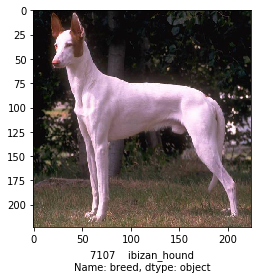

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 18ms/step
The best matches:
breed ibizan_hound
	 with accuarcy: 0.2841132581233978
breed komondor
	 with accuarcy: 0.12827089428901672
breed clumber
	 with accuarcy: 0.10461989790201187
breed borzoi
	 with accuarcy: 0.06398772448301315
breed great_pyrenees
	 with accuarcy: 0.03267894312739372


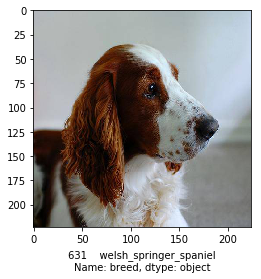

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 14ms/step
The best matches:
breed rhodesian_ridgeback
	 with accuarcy: 0.30634212493896484
breed irish_terrier
	 with accuarcy: 0.11472966521978378
breed vizsla
	 with accuarcy: 0.09104324132204056
breed redbone
	 with accuarcy: 0.047592584043741226
breed irish_setter
	 with accuarcy: 0.047134216874837875


In [223]:
bestPreds(firstModel, 'b25f133c4dffc6d1eba2ae381ecb6d18', 5)
bestPreds(firstModel, '0f7c817dd5f8b8d6b57e3b7f3e2f4f56', 5)

The model produced a correct classification of the Ibizan hound but still no luck on the Welsh Springer Spaniel. But the certainty of the model is still low as the classification was correct but with 28% accuarcy, this might not be the case if there was a wider range of samples of the dog. Lets see more examples for a better understanding.

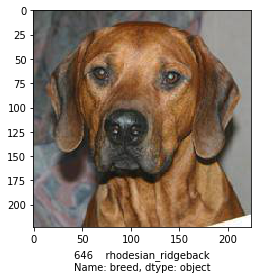

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
The best matches:
breed vizsla
	 with accuarcy: 0.3190545439720154
breed rhodesian_ridgeback
	 with accuarcy: 0.2113392949104309
breed redbone
	 with accuarcy: 0.08616168797016144
breed irish_terrier
	 with accuarcy: 0.07977074384689331
breed chow
	 with accuarcy: 0.053405847400426865


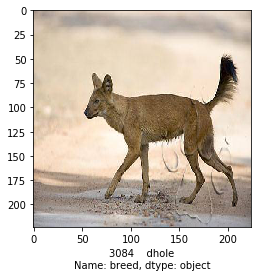

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 14ms/step
The best matches:
breed dhole
	 with accuarcy: 0.3455401062965393
breed leonberg
	 with accuarcy: 0.14234553277492523
breed rhodesian_ridgeback
	 with accuarcy: 0.13080547749996185
breed dingo
	 with accuarcy: 0.07749317586421967
breed shetland_sheepdog
	 with accuarcy: 0.03661700338125229


In [224]:
bestPreds(firstModel, '0fc1bd3c4d89b3f89dc91605032fa8f9', 5)
bestPreds(firstModel, '4c2ca9ee822b5ab533a73422fadafec9', 5)

Overall the model saw improvements but its is still hit or miss. We can notice that the Rhodesian Ridgeback was misclassified only by one other breed class. Lets try changing the model to see if we can yield better results with a faster rate. The models current optimizer is SGD, we will try the Adam optimizer as it also as SGD a gradient based optimization.
The Adam optimizer might do a better job empirical results demonstrate that Adam works well in practice and compares favorably to other stochastic optimization methods. 

Lets try to run the new model with the same number of batch size and epochs as the last one to see how they compare.

In [227]:
def prepareSecondModel(num_class):
    base_model = VGG19(#weights='imagenet',
        weights = None, include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)



    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    return model

In [229]:
secondModel = prepareSecondModel(120)
secondModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [231]:
secondModel.fit(X_train, Y_train,
               epochs=15, validation_data=(X_valid, Y_valid), 
               verbose=1, batch_size=25
              ,callbacks=callbacks_list)

Train on 8688 samples, validate on 1534 samples
Epoch 1/15


5050/8688 [================>.............] - ETA: 7:34 - loss: 4.7884 - acc: 0.0000e+0 - ETA: 4:57 - loss: 10.4533 - acc: 0.0000e+ - ETA: 4:05 - loss: 12.3415 - acc: 0.0000e+ - ETA: 3:38 - loss: 13.1245 - acc: 0.0100   - ETA: 3:22 - loss: 13.5943 - acc: 0.01 - ETA: 3:12 - loss: 14.0149 - acc: 0.01 - ETA: 3:04 - loss: 14.3154 - acc: 0.01 - ETA: 2:58 - loss: 14.5407 - acc: 0.01 - ETA: 2:53 - loss: 14.7160 - acc: 0.00 - ETA: 2:49 - loss: 14.7917 - acc: 0.01 - ETA: 2:46 - loss: 14.8537 - acc: 0.01 - ETA: 2:43 - loss: 14.9590 - acc: 0.01 - ETA: 2:41 - loss: 15.0482 - acc: 0.01 - ETA: 2:39 - loss: 15.1246 - acc: 0.01 - ETA: 2:37 - loss: 15.1909 - acc: 0.01 - ETA: 2:35 - loss: 15.2488 - acc: 0.01 - ETA: 2:34 - loss: 15.2999 - acc: 0.00 - ETA: 2:32 - loss: 15.3454 - acc: 0.00 - ETA: 2:31 - loss: 15.3521 - acc: 0.01 - ETA: 2:29 - loss: 15.3904 - acc: 0.01 - ETA: 2:28 - loss: 15.4251 - acc: 0.00 - ETA: 2:27 - loss: 15.4566 - acc: 0.00 - ETA: 2:26 - loss: 15.4853 - acc: 0.00 - ETA: 2:25 - loss: 1

5100/8688 [================>.............] - ETA: 2:22 - loss: 15.4734 - acc: 0.04 - ETA: 2:20 - loss: 15.4734 - acc: 0.04 - ETA: 2:22 - loss: 15.6883 - acc: 0.02 - ETA: 2:22 - loss: 15.6346 - acc: 0.03 - ETA: 2:21 - loss: 15.7313 - acc: 0.02 - ETA: 2:20 - loss: 15.6883 - acc: 0.02 - ETA: 2:19 - loss: 15.7497 - acc: 0.02 - ETA: 2:19 - loss: 15.7151 - acc: 0.02 - ETA: 2:18 - loss: 15.7599 - acc: 0.02 - ETA: 2:18 - loss: 15.7957 - acc: 0.02 - ETA: 2:17 - loss: 15.8250 - acc: 0.01 - ETA: 2:17 - loss: 15.8495 - acc: 0.01 - ETA: 2:17 - loss: 15.8701 - acc: 0.01 - ETA: 2:16 - loss: 15.8878 - acc: 0.01 - ETA: 2:16 - loss: 15.9032 - acc: 0.01 - ETA: 2:16 - loss: 15.9166 - acc: 0.01 - ETA: 2:15 - loss: 15.9285 - acc: 0.01 - ETA: 2:15 - loss: 15.9390 - acc: 0.01 - ETA: 2:14 - loss: 15.9145 - acc: 0.01 - ETA: 2:14 - loss: 15.9247 - acc: 0.01 - ETA: 2:13 - loss: 15.9339 - acc: 0.01 - ETA: 2:13 - loss: 15.9423 - acc: 0.01 - ETA: 2:12 - loss: 15.9499 - acc: 0.01 - ETA: 2:12 - loss: 15.9569 - acc: 0.

8688/8688 [==============================] - ETA: 58s - loss: 15.9200 - acc: 0.012 - ETA: 57s - loss: 15.9209 - acc: 0.012 - ETA: 57s - loss: 15.9219 - acc: 0.012 - ETA: 57s - loss: 15.9228 - acc: 0.012 - ETA: 56s - loss: 15.9238 - acc: 0.012 - ETA: 56s - loss: 15.9247 - acc: 0.012 - ETA: 55s - loss: 15.9256 - acc: 0.011 - ETA: 55s - loss: 15.9265 - acc: 0.011 - ETA: 54s - loss: 15.9274 - acc: 0.011 - ETA: 54s - loss: 15.9283 - acc: 0.011 - ETA: 54s - loss: 15.9292 - acc: 0.011 - ETA: 53s - loss: 15.9301 - acc: 0.011 - ETA: 53s - loss: 15.9309 - acc: 0.011 - ETA: 52s - loss: 15.9318 - acc: 0.011 - ETA: 52s - loss: 15.9326 - acc: 0.011 - ETA: 52s - loss: 15.9335 - acc: 0.011 - ETA: 51s - loss: 15.9343 - acc: 0.011 - ETA: 51s - loss: 15.9351 - acc: 0.011 - ETA: 50s - loss: 15.9360 - acc: 0.011 - ETA: 50s - loss: 15.9339 - acc: 0.011 - ETA: 50s - loss: 15.9318 - acc: 0.011 - ETA: 49s - loss: 15.9327 - acc: 0.011 - ETA: 49s - loss: 15.9335 - acc: 0.011 - ETA: 48s - loss: 15.9343 - acc: 0.0

5100/8688 [================>.............] - ETA: 2:20 - loss: 15.4734 - acc: 0.04 - ETA: 2:19 - loss: 15.7957 - acc: 0.02 - ETA: 2:19 - loss: 15.9032 - acc: 0.01 - ETA: 2:19 - loss: 15.9569 - acc: 0.01 - ETA: 2:18 - loss: 15.8602 - acc: 0.01 - ETA: 2:18 - loss: 15.9032 - acc: 0.01 - ETA: 2:17 - loss: 15.9339 - acc: 0.01 - ETA: 2:17 - loss: 15.8763 - acc: 0.01 - ETA: 2:17 - loss: 15.8316 - acc: 0.01 - ETA: 2:16 - loss: 15.8602 - acc: 0.01 - ETA: 2:16 - loss: 15.8250 - acc: 0.01 - ETA: 2:15 - loss: 15.8495 - acc: 0.01 - ETA: 2:15 - loss: 15.8701 - acc: 0.01 - ETA: 2:15 - loss: 15.8418 - acc: 0.01 - ETA: 2:14 - loss: 15.8602 - acc: 0.01 - ETA: 2:14 - loss: 15.8360 - acc: 0.01 - ETA: 2:14 - loss: 15.8526 - acc: 0.01 - ETA: 2:13 - loss: 15.8674 - acc: 0.01 - ETA: 2:13 - loss: 15.8806 - acc: 0.01 - ETA: 2:12 - loss: 15.8602 - acc: 0.01 - ETA: 2:12 - loss: 15.8725 - acc: 0.01 - ETA: 2:12 - loss: 15.8543 - acc: 0.01 - ETA: 2:11 - loss: 15.8658 - acc: 0.01 - ETA: 2:11 - loss: 15.8495 - acc: 0.

5100/8688 [================>.............] - ETA: 2:23 - loss: 16.1181 - acc: 0.0000e+ - ETA: 2:21 - loss: 16.1181 - acc: 0.0000e+ - ETA: 2:21 - loss: 15.9032 - acc: 0.0133   - ETA: 2:21 - loss: 15.9569 - acc: 0.01 - ETA: 2:20 - loss: 15.9892 - acc: 0.00 - ETA: 2:20 - loss: 15.9032 - acc: 0.01 - ETA: 2:19 - loss: 15.8418 - acc: 0.01 - ETA: 2:19 - loss: 15.8763 - acc: 0.01 - ETA: 2:18 - loss: 15.9032 - acc: 0.01 - ETA: 2:18 - loss: 15.9247 - acc: 0.01 - ETA: 2:17 - loss: 15.8837 - acc: 0.01 - ETA: 2:17 - loss: 15.9032 - acc: 0.01 - ETA: 2:16 - loss: 15.9197 - acc: 0.01 - ETA: 2:16 - loss: 15.9339 - acc: 0.01 - ETA: 2:15 - loss: 15.9462 - acc: 0.01 - ETA: 2:15 - loss: 15.9569 - acc: 0.01 - ETA: 2:15 - loss: 15.9664 - acc: 0.00 - ETA: 2:14 - loss: 15.9748 - acc: 0.00 - ETA: 2:14 - loss: 15.9484 - acc: 0.01 - ETA: 2:13 - loss: 15.9569 - acc: 0.01 - ETA: 2:13 - loss: 15.9646 - acc: 0.00 - ETA: 2:13 - loss: 15.9716 - acc: 0.00 - ETA: 2:12 - loss: 15.9499 - acc: 0.01 - ETA: 2:12 - loss: 15.95

8688/8688 [==============================] - ETA: 58s - loss: 15.9200 - acc: 0.012 - ETA: 57s - loss: 15.9209 - acc: 0.012 - ETA: 57s - loss: 15.9188 - acc: 0.012 - ETA: 56s - loss: 15.9197 - acc: 0.012 - ETA: 56s - loss: 15.9207 - acc: 0.012 - ETA: 56s - loss: 15.9185 - acc: 0.012 - ETA: 55s - loss: 15.9195 - acc: 0.012 - ETA: 55s - loss: 15.9204 - acc: 0.012 - ETA: 54s - loss: 15.9213 - acc: 0.012 - ETA: 54s - loss: 15.9223 - acc: 0.012 - ETA: 54s - loss: 15.9202 - acc: 0.012 - ETA: 53s - loss: 15.9211 - acc: 0.012 - ETA: 53s - loss: 15.9220 - acc: 0.012 - ETA: 52s - loss: 15.9199 - acc: 0.012 - ETA: 52s - loss: 15.9209 - acc: 0.012 - ETA: 52s - loss: 15.9217 - acc: 0.012 - ETA: 51s - loss: 15.9226 - acc: 0.012 - ETA: 51s - loss: 15.9235 - acc: 0.012 - ETA: 50s - loss: 15.9244 - acc: 0.012 - ETA: 50s - loss: 15.9253 - acc: 0.012 - ETA: 50s - loss: 15.9232 - acc: 0.012 - ETA: 49s - loss: 15.9241 - acc: 0.012 - ETA: 49s - loss: 15.9221 - acc: 0.012 - ETA: 48s - loss: 15.9230 - acc: 0.0

5100/8688 [================>.............] - ETA: 2:20 - loss: 16.1181 - acc: 0.0000e+ - ETA: 2:20 - loss: 15.7957 - acc: 0.0200   - ETA: 2:20 - loss: 15.9032 - acc: 0.01 - ETA: 2:20 - loss: 15.9569 - acc: 0.01 - ETA: 2:19 - loss: 15.7313 - acc: 0.02 - ETA: 2:19 - loss: 15.7957 - acc: 0.02 - ETA: 2:19 - loss: 15.8418 - acc: 0.01 - ETA: 2:18 - loss: 15.8763 - acc: 0.01 - ETA: 2:18 - loss: 15.8316 - acc: 0.01 - ETA: 2:18 - loss: 15.8602 - acc: 0.01 - ETA: 2:18 - loss: 15.8837 - acc: 0.01 - ETA: 2:17 - loss: 15.8495 - acc: 0.01 - ETA: 2:17 - loss: 15.8701 - acc: 0.01 - ETA: 2:16 - loss: 15.8878 - acc: 0.01 - ETA: 2:16 - loss: 15.8602 - acc: 0.01 - ETA: 2:15 - loss: 15.8360 - acc: 0.01 - ETA: 2:15 - loss: 15.8526 - acc: 0.01 - ETA: 2:15 - loss: 15.8674 - acc: 0.01 - ETA: 2:14 - loss: 15.8806 - acc: 0.01 - ETA: 2:14 - loss: 15.8924 - acc: 0.01 - ETA: 2:14 - loss: 15.9032 - acc: 0.01 - ETA: 2:13 - loss: 15.9130 - acc: 0.01 - ETA: 2:13 - loss: 15.9219 - acc: 0.01 - ETA: 2:12 - loss: 15.9301 -

5100/8688 [================>.............] - ETA: 2:21 - loss: 15.4734 - acc: 0.04 - ETA: 2:21 - loss: 15.7957 - acc: 0.02 - ETA: 2:21 - loss: 15.6883 - acc: 0.02 - ETA: 2:21 - loss: 15.7957 - acc: 0.02 - ETA: 2:20 - loss: 15.8602 - acc: 0.01 - ETA: 2:20 - loss: 15.9032 - acc: 0.01 - ETA: 2:19 - loss: 15.9339 - acc: 0.01 - ETA: 2:19 - loss: 15.7151 - acc: 0.02 - ETA: 2:18 - loss: 15.7599 - acc: 0.02 - ETA: 2:18 - loss: 15.7957 - acc: 0.02 - ETA: 2:18 - loss: 15.8250 - acc: 0.01 - ETA: 2:17 - loss: 15.8495 - acc: 0.01 - ETA: 2:17 - loss: 15.8701 - acc: 0.01 - ETA: 2:16 - loss: 15.8878 - acc: 0.01 - ETA: 2:16 - loss: 15.9032 - acc: 0.01 - ETA: 2:15 - loss: 15.9166 - acc: 0.01 - ETA: 2:15 - loss: 15.9285 - acc: 0.01 - ETA: 2:14 - loss: 15.9390 - acc: 0.01 - ETA: 2:14 - loss: 15.9484 - acc: 0.01 - ETA: 2:14 - loss: 15.9569 - acc: 0.01 - ETA: 2:13 - loss: 15.9646 - acc: 0.00 - ETA: 2:13 - loss: 15.9716 - acc: 0.00 - ETA: 2:12 - loss: 15.9779 - acc: 0.00 - ETA: 2:12 - loss: 15.9569 - acc: 0.

8688/8688 [==============================] - ETA: 58s - loss: 15.9200 - acc: 0.012 - ETA: 58s - loss: 15.9209 - acc: 0.012 - ETA: 57s - loss: 15.9188 - acc: 0.012 - ETA: 57s - loss: 15.9197 - acc: 0.012 - ETA: 56s - loss: 15.9207 - acc: 0.012 - ETA: 56s - loss: 15.9216 - acc: 0.012 - ETA: 56s - loss: 15.9195 - acc: 0.012 - ETA: 55s - loss: 15.9174 - acc: 0.012 - ETA: 55s - loss: 15.9183 - acc: 0.012 - ETA: 54s - loss: 15.9193 - acc: 0.012 - ETA: 54s - loss: 15.9202 - acc: 0.012 - ETA: 54s - loss: 15.9211 - acc: 0.012 - ETA: 53s - loss: 15.9161 - acc: 0.012 - ETA: 53s - loss: 15.9170 - acc: 0.012 - ETA: 52s - loss: 15.9179 - acc: 0.012 - ETA: 52s - loss: 15.9188 - acc: 0.012 - ETA: 51s - loss: 15.9197 - acc: 0.012 - ETA: 51s - loss: 15.9206 - acc: 0.012 - ETA: 51s - loss: 15.9215 - acc: 0.012 - ETA: 50s - loss: 15.9224 - acc: 0.012 - ETA: 50s - loss: 15.9232 - acc: 0.012 - ETA: 49s - loss: 15.9241 - acc: 0.012 - ETA: 49s - loss: 15.9250 - acc: 0.012 - ETA: 49s - loss: 15.9258 - acc: 0.0

5100/8688 [================>.............] - ETA: 2:21 - loss: 15.4734 - acc: 0.04 - ETA: 2:21 - loss: 15.7957 - acc: 0.02 - ETA: 2:21 - loss: 15.9032 - acc: 0.01 - ETA: 2:21 - loss: 15.7957 - acc: 0.02 - ETA: 2:20 - loss: 15.7313 - acc: 0.02 - ETA: 2:20 - loss: 15.7957 - acc: 0.02 - ETA: 2:19 - loss: 15.8418 - acc: 0.01 - ETA: 2:19 - loss: 15.8763 - acc: 0.01 - ETA: 2:19 - loss: 15.9032 - acc: 0.01 - ETA: 2:18 - loss: 15.9247 - acc: 0.01 - ETA: 2:18 - loss: 15.9423 - acc: 0.01 - ETA: 2:17 - loss: 15.9569 - acc: 0.01 - ETA: 2:17 - loss: 15.9693 - acc: 0.00 - ETA: 2:16 - loss: 15.9799 - acc: 0.00 - ETA: 2:16 - loss: 15.9462 - acc: 0.01 - ETA: 2:16 - loss: 15.8763 - acc: 0.01 - ETA: 2:15 - loss: 15.8526 - acc: 0.01 - ETA: 2:15 - loss: 15.8674 - acc: 0.01 - ETA: 2:14 - loss: 15.8806 - acc: 0.01 - ETA: 2:14 - loss: 15.8924 - acc: 0.01 - ETA: 2:14 - loss: 15.8725 - acc: 0.01 - ETA: 2:13 - loss: 15.8837 - acc: 0.01 - ETA: 2:13 - loss: 15.8938 - acc: 0.01 - ETA: 2:12 - loss: 15.9032 - acc: 0.

5100/8688 [================>.............] - ETA: 2:19 - loss: 16.1181 - acc: 0.0000e+ - ETA: 2:19 - loss: 16.1181 - acc: 0.0000e+ - ETA: 2:19 - loss: 16.1181 - acc: 0.0000e+ - ETA: 2:18 - loss: 16.1181 - acc: 0.0000e+ - ETA: 2:18 - loss: 16.1181 - acc: 0.0000e+ - ETA: 2:18 - loss: 16.0106 - acc: 0.0067   - ETA: 2:17 - loss: 16.0260 - acc: 0.00 - ETA: 2:17 - loss: 15.8763 - acc: 0.01 - ETA: 2:16 - loss: 15.9032 - acc: 0.01 - ETA: 2:16 - loss: 15.9247 - acc: 0.01 - ETA: 2:16 - loss: 15.9423 - acc: 0.01 - ETA: 2:15 - loss: 15.9569 - acc: 0.01 - ETA: 2:15 - loss: 15.9693 - acc: 0.00 - ETA: 2:15 - loss: 15.9799 - acc: 0.00 - ETA: 2:14 - loss: 15.9892 - acc: 0.00 - ETA: 2:14 - loss: 15.9972 - acc: 0.00 - ETA: 2:13 - loss: 16.0043 - acc: 0.00 - ETA: 2:13 - loss: 15.9748 - acc: 0.00 - ETA: 2:13 - loss: 15.9824 - acc: 0.00 - ETA: 2:12 - loss: 15.9892 - acc: 0.00 - ETA: 2:12 - loss: 15.9953 - acc: 0.00 - ETA: 2:12 - loss: 16.0009 - acc: 0.00 - ETA: 2:11 - loss: 15.9779 - acc: 0.00 - ETA: 2:11 -

8688/8688 [==============================] - ETA: 57s - loss: 15.9231 - acc: 0.012 - ETA: 57s - loss: 15.9209 - acc: 0.012 - ETA: 57s - loss: 15.9219 - acc: 0.012 - ETA: 56s - loss: 15.9197 - acc: 0.012 - ETA: 56s - loss: 15.9207 - acc: 0.012 - ETA: 55s - loss: 15.9216 - acc: 0.012 - ETA: 55s - loss: 15.9225 - acc: 0.012 - ETA: 55s - loss: 15.9235 - acc: 0.012 - ETA: 54s - loss: 15.9244 - acc: 0.012 - ETA: 54s - loss: 15.9253 - acc: 0.012 - ETA: 53s - loss: 15.9232 - acc: 0.012 - ETA: 53s - loss: 15.9241 - acc: 0.012 - ETA: 53s - loss: 15.9220 - acc: 0.012 - ETA: 52s - loss: 15.9229 - acc: 0.012 - ETA: 52s - loss: 15.9209 - acc: 0.012 - ETA: 51s - loss: 15.9188 - acc: 0.012 - ETA: 51s - loss: 15.9168 - acc: 0.012 - ETA: 51s - loss: 15.9177 - acc: 0.012 - ETA: 50s - loss: 15.9186 - acc: 0.012 - ETA: 50s - loss: 15.9195 - acc: 0.012 - ETA: 49s - loss: 15.9204 - acc: 0.012 - ETA: 49s - loss: 15.9213 - acc: 0.012 - ETA: 48s - loss: 15.9193 - acc: 0.012 - ETA: 48s - loss: 15.9202 - acc: 0.0

5100/8688 [================>.............] - ETA: 2:19 - loss: 16.1181 - acc: 0.0000e+ - ETA: 2:19 - loss: 16.1181 - acc: 0.0000e+ - ETA: 2:19 - loss: 15.9032 - acc: 0.0133   - ETA: 2:18 - loss: 15.9569 - acc: 0.01 - ETA: 2:18 - loss: 15.9892 - acc: 0.00 - ETA: 2:17 - loss: 15.9032 - acc: 0.01 - ETA: 2:17 - loss: 15.9339 - acc: 0.01 - ETA: 2:16 - loss: 15.9569 - acc: 0.01 - ETA: 2:16 - loss: 15.9748 - acc: 0.00 - ETA: 2:16 - loss: 15.9892 - acc: 0.00 - ETA: 2:15 - loss: 15.9423 - acc: 0.01 - ETA: 2:15 - loss: 15.9569 - acc: 0.01 - ETA: 2:15 - loss: 15.9197 - acc: 0.01 - ETA: 2:14 - loss: 15.8878 - acc: 0.01 - ETA: 2:14 - loss: 15.9032 - acc: 0.01 - ETA: 2:14 - loss: 15.9166 - acc: 0.01 - ETA: 2:13 - loss: 15.9285 - acc: 0.01 - ETA: 2:13 - loss: 15.9390 - acc: 0.01 - ETA: 2:12 - loss: 15.9484 - acc: 0.01 - ETA: 2:12 - loss: 15.9569 - acc: 0.01 - ETA: 2:12 - loss: 15.9646 - acc: 0.00 - ETA: 2:11 - loss: 15.9716 - acc: 0.00 - ETA: 2:11 - loss: 15.9779 - acc: 0.00 - ETA: 2:11 - loss: 15.93

5100/8688 [================>.............] - ETA: 2:19 - loss: 15.4734 - acc: 0.04 - ETA: 2:20 - loss: 15.7957 - acc: 0.02 - ETA: 2:20 - loss: 15.9032 - acc: 0.01 - ETA: 2:20 - loss: 15.9569 - acc: 0.01 - ETA: 2:20 - loss: 15.9892 - acc: 0.00 - ETA: 2:19 - loss: 15.9032 - acc: 0.01 - ETA: 2:19 - loss: 15.9339 - acc: 0.01 - ETA: 2:18 - loss: 15.9569 - acc: 0.01 - ETA: 2:18 - loss: 15.9748 - acc: 0.00 - ETA: 2:18 - loss: 15.9247 - acc: 0.01 - ETA: 2:17 - loss: 15.9423 - acc: 0.01 - ETA: 2:17 - loss: 15.9569 - acc: 0.01 - ETA: 2:16 - loss: 15.9197 - acc: 0.01 - ETA: 2:16 - loss: 15.9339 - acc: 0.01 - ETA: 2:16 - loss: 15.9462 - acc: 0.01 - ETA: 2:15 - loss: 15.9569 - acc: 0.01 - ETA: 2:15 - loss: 15.9664 - acc: 0.00 - ETA: 2:14 - loss: 15.9748 - acc: 0.00 - ETA: 2:14 - loss: 15.9824 - acc: 0.00 - ETA: 2:14 - loss: 15.9892 - acc: 0.00 - ETA: 2:13 - loss: 15.9953 - acc: 0.00 - ETA: 2:13 - loss: 16.0009 - acc: 0.00 - ETA: 2:12 - loss: 16.0060 - acc: 0.00 - ETA: 2:12 - loss: 16.0106 - acc: 0.

8688/8688 [==============================] - ETA: 58s - loss: 15.9420 - acc: 0.010 - ETA: 57s - loss: 15.9428 - acc: 0.010 - ETA: 57s - loss: 15.9437 - acc: 0.010 - ETA: 57s - loss: 15.9414 - acc: 0.011 - ETA: 56s - loss: 15.9423 - acc: 0.010 - ETA: 56s - loss: 15.9431 - acc: 0.010 - ETA: 55s - loss: 15.9409 - acc: 0.011 - ETA: 55s - loss: 15.9417 - acc: 0.010 - ETA: 55s - loss: 15.9425 - acc: 0.010 - ETA: 54s - loss: 15.9373 - acc: 0.011 - ETA: 54s - loss: 15.9352 - acc: 0.011 - ETA: 53s - loss: 15.9360 - acc: 0.011 - ETA: 53s - loss: 15.9369 - acc: 0.011 - ETA: 52s - loss: 15.9377 - acc: 0.011 - ETA: 52s - loss: 15.9385 - acc: 0.011 - ETA: 52s - loss: 15.9393 - acc: 0.011 - ETA: 51s - loss: 15.9401 - acc: 0.011 - ETA: 51s - loss: 15.9409 - acc: 0.011 - ETA: 51s - loss: 15.9417 - acc: 0.010 - ETA: 50s - loss: 15.9425 - acc: 0.010 - ETA: 50s - loss: 15.9404 - acc: 0.011 - ETA: 49s - loss: 15.9384 - acc: 0.011 - ETA: 49s - loss: 15.9392 - acc: 0.011 - ETA: 49s - loss: 15.9399 - acc: 0.0

5100/8688 [================>.............] - ETA: 2:19 - loss: 16.1181 - acc: 0.0000e+ - ETA: 2:19 - loss: 15.7957 - acc: 0.0200   - ETA: 2:19 - loss: 15.9032 - acc: 0.01 - ETA: 2:19 - loss: 15.9569 - acc: 0.01 - ETA: 2:19 - loss: 15.9892 - acc: 0.00 - ETA: 2:18 - loss: 16.0106 - acc: 0.00 - ETA: 2:18 - loss: 16.0260 - acc: 0.00 - ETA: 2:18 - loss: 16.0375 - acc: 0.00 - ETA: 2:17 - loss: 16.0465 - acc: 0.00 - ETA: 2:17 - loss: 16.0536 - acc: 0.00 - ETA: 2:17 - loss: 16.0595 - acc: 0.00 - ETA: 2:16 - loss: 16.0644 - acc: 0.00 - ETA: 2:16 - loss: 16.0189 - acc: 0.00 - ETA: 2:16 - loss: 15.9799 - acc: 0.00 - ETA: 2:16 - loss: 15.9892 - acc: 0.00 - ETA: 2:15 - loss: 15.9972 - acc: 0.00 - ETA: 2:15 - loss: 16.0043 - acc: 0.00 - ETA: 2:15 - loss: 16.0106 - acc: 0.00 - ETA: 2:14 - loss: 16.0163 - acc: 0.00 - ETA: 2:14 - loss: 16.0214 - acc: 0.00 - ETA: 2:13 - loss: 16.0260 - acc: 0.00 - ETA: 2:13 - loss: 16.0302 - acc: 0.00 - ETA: 2:12 - loss: 16.0060 - acc: 0.00 - ETA: 2:12 - loss: 15.9838 -

We can see that the model was not trained well, as the best accuarcy value was 6.454% and the training stopped because of no consistent improvement. Also, the accuarcy loss is very high compared to the previous model. Something is wrong with the configuration of the model. lets see how it its capabilities on our featured examples.

In [252]:
preds = secondModel.predict(x_test_raw, verbose=1)

10357/10357 [==============================] - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ET

In [254]:
sub = pd.DataFrame(preds)
col_names = one_hot.columns.values
sub.columns = col_names
sub.insert(0, 'id', df_test['id'])
sub.head(5)

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e            0.0           0.0   
1  00102ee9d8eb90812350685311fe5890            0.0           0.0   
2  0012a730dfa437f5f3613fb75efcd4ce            0.0           0.0   
3  001510bc8570bbeee98c8d80c8a95ec1            0.0           0.0   
4  001a5f3114548acdefa3d4da05474c2e            0.0           0.0   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0                  0.0       0.0                             0.0          0.0   
1                  0.0       0.0                             0.0          0.0   
2                  0.0       0.0                             0.0          0.0   
3                  0.0       0.0                             0.0          0.0   
4                  0.0       0.0                             0.0          0.0   

   australian_terrier  basenji  basset        ...          toy_poodle  \
0                 0.0      0.0     0.0        ...                 0.0   
1                 0.0      0.0     0.0        ...                 0.0   
2                 0.0      0.0     0.0        ...                 0.0   
3                 0.0      0.0     0.0        ...                 0.0   
4                 0.0      0.0     0.0        ...                 0.0   

   toy_terrier  vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0          0.0     0.0           0.0         0.0                     0.0   
1          0.0     0.0           0.0         0.0                     0.0   
2          0.0     0.0           0.0         0.0                     0.0   
3          0.0     0.0           0.0         0.0                     0.0   
4          0.0     0.0           0.0         0.0                     0.0   

   west_highland_white_terrier  whippet  wire-haired_fox_terrier  \
0                          0.0      0.0                      0.0   
1                          0.0      0.0                      0.0   
2                          0.0      0.0                      0.0   
3                          0.0      0.0                      0.0   
4                          0.0      0.0                      0.0   

   yorkshire_terrier  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  

[5 rows x 121 columns]

We can see that our model is way off now. After a bit of research, we can modify our model by freezing the layers and stop them from training.

In [256]:

def prepareThirdModel(num_class):
    base_model = VGG19(#weights='imagenet',
        weights = None, include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

    return model

In [257]:
thirdModel = prepareThirdModel(120)
thirdModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [258]:
thirdModel.fit(X_train, Y_train,
               epochs=15, validation_data=(X_valid, Y_valid), 
               verbose=1, batch_size=25
              ,callbacks=callbacks_list)

Train on 8688 samples, validate on 1534 samples
Epoch 1/15


5300/8688 [=================>............] - ETA: 3:42 - loss: 4.8249 - acc: 0.0000e+0 - ETA: 2:19 - loss: 5.0873 - acc: 0.0200    - ETA: 1:50 - loss: 5.5302 - acc: 0.026 - ETA: 1:36 - loss: 5.7815 - acc: 0.020 - ETA: 1:27 - loss: 5.9209 - acc: 0.032 - ETA: 1:21 - loss: 6.0371 - acc: 0.033 - ETA: 1:17 - loss: 6.1958 - acc: 0.028 - ETA: 1:14 - loss: 6.3967 - acc: 0.025 - ETA: 1:11 - loss: 6.4093 - acc: 0.022 - ETA: 1:09 - loss: 6.4254 - acc: 0.020 - ETA: 1:08 - loss: 6.5088 - acc: 0.018 - ETA: 1:06 - loss: 6.4542 - acc: 0.020 - ETA: 1:05 - loss: 6.4074 - acc: 0.018 - ETA: 1:04 - loss: 6.3893 - acc: 0.017 - ETA: 1:03 - loss: 6.4648 - acc: 0.016 - ETA: 1:02 - loss: 6.5874 - acc: 0.015 - ETA: 1:01 - loss: 6.5599 - acc: 0.014 - ETA: 1:01 - loss: 6.5711 - acc: 0.013 - ETA: 1:00 - loss: 6.5519 - acc: 0.012 - ETA: 59s - loss: 6.5744 - acc: 0.012 - ETA: 59s - loss: 6.5706 - acc: 0.01 - ETA: 58s - loss: 6.5208 - acc: 0.01 - ETA: 58s - loss: 6.4963 - acc: 0.01 - ETA: 57s - loss: 6.4530 - acc: 0.0

5375/8688 [=================>............] - ETA: 53s - loss: 5.1987 - acc: 0.04 - ETA: 53s - loss: 4.9654 - acc: 0.04 - ETA: 54s - loss: 5.2441 - acc: 0.02 - ETA: 54s - loss: 5.1654 - acc: 0.02 - ETA: 54s - loss: 5.0937 - acc: 0.02 - ETA: 53s - loss: 5.0061 - acc: 0.03 - ETA: 53s - loss: 5.0612 - acc: 0.02 - ETA: 53s - loss: 5.1404 - acc: 0.03 - ETA: 53s - loss: 5.1397 - acc: 0.02 - ETA: 53s - loss: 5.1278 - acc: 0.02 - ETA: 52s - loss: 5.0969 - acc: 0.02 - ETA: 52s - loss: 5.0384 - acc: 0.03 - ETA: 52s - loss: 5.0598 - acc: 0.03 - ETA: 52s - loss: 5.0369 - acc: 0.03 - ETA: 52s - loss: 5.0440 - acc: 0.03 - ETA: 52s - loss: 5.0716 - acc: 0.03 - ETA: 52s - loss: 5.0698 - acc: 0.02 - ETA: 51s - loss: 5.0920 - acc: 0.02 - ETA: 51s - loss: 5.0584 - acc: 0.02 - ETA: 51s - loss: 5.0708 - acc: 0.02 - ETA: 51s - loss: 5.0559 - acc: 0.03 - ETA: 51s - loss: 5.0587 - acc: 0.03 - ETA: 51s - loss: 5.0517 - acc: 0.03 - ETA: 51s - loss: 5.0389 - acc: 0.03 - ETA: 51s - loss: 5.0631 - acc: 0.03 - ETA: 

8688/8688 [==============================] - ETA: 20s - loss: 5.0740 - acc: 0.03 - ETA: 20s - loss: 5.0703 - acc: 0.03 - ETA: 20s - loss: 5.0700 - acc: 0.03 - ETA: 20s - loss: 5.0705 - acc: 0.03 - ETA: 20s - loss: 5.0700 - acc: 0.03 - ETA: 19s - loss: 5.0685 - acc: 0.03 - ETA: 19s - loss: 5.0694 - acc: 0.03 - ETA: 19s - loss: 5.0696 - acc: 0.03 - ETA: 19s - loss: 5.0712 - acc: 0.03 - ETA: 19s - loss: 5.0695 - acc: 0.03 - ETA: 19s - loss: 5.0692 - acc: 0.03 - ETA: 19s - loss: 5.0683 - acc: 0.03 - ETA: 18s - loss: 5.0701 - acc: 0.03 - ETA: 18s - loss: 5.0705 - acc: 0.03 - ETA: 18s - loss: 5.0705 - acc: 0.03 - ETA: 18s - loss: 5.0703 - acc: 0.03 - ETA: 18s - loss: 5.0672 - acc: 0.03 - ETA: 18s - loss: 5.0708 - acc: 0.03 - ETA: 17s - loss: 5.0715 - acc: 0.03 - ETA: 17s - loss: 5.0719 - acc: 0.03 - ETA: 17s - loss: 5.0727 - acc: 0.03 - ETA: 17s - loss: 5.0716 - acc: 0.03 - ETA: 17s - loss: 5.0691 - acc: 0.03 - ETA: 17s - loss: 5.0699 - acc: 0.03 - ETA: 16s - loss: 5.0711 - acc: 0.03 - ETA: 

5375/8688 [=================>............] - ETA: 52s - loss: 4.3751 - acc: 0.04 - ETA: 53s - loss: 4.5026 - acc: 0.04 - ETA: 54s - loss: 4.8147 - acc: 0.02 - ETA: 54s - loss: 4.7164 - acc: 0.05 - ETA: 53s - loss: 4.6630 - acc: 0.06 - ETA: 53s - loss: 4.7396 - acc: 0.05 - ETA: 53s - loss: 4.8156 - acc: 0.04 - ETA: 53s - loss: 4.7955 - acc: 0.05 - ETA: 53s - loss: 4.7901 - acc: 0.05 - ETA: 53s - loss: 4.7838 - acc: 0.06 - ETA: 52s - loss: 4.7794 - acc: 0.05 - ETA: 52s - loss: 4.7592 - acc: 0.05 - ETA: 52s - loss: 4.7539 - acc: 0.04 - ETA: 52s - loss: 4.7215 - acc: 0.05 - ETA: 52s - loss: 4.6678 - acc: 0.06 - ETA: 52s - loss: 4.6626 - acc: 0.06 - ETA: 51s - loss: 4.6856 - acc: 0.06 - ETA: 51s - loss: 4.6933 - acc: 0.06 - ETA: 51s - loss: 4.7390 - acc: 0.06 - ETA: 51s - loss: 4.7257 - acc: 0.06 - ETA: 51s - loss: 4.7459 - acc: 0.06 - ETA: 51s - loss: 4.7616 - acc: 0.05 - ETA: 51s - loss: 4.7431 - acc: 0.05 - ETA: 50s - loss: 4.7648 - acc: 0.05 - ETA: 50s - loss: 4.7778 - acc: 0.05 - ETA: 

5375/8688 [=================>............] - ETA: 53s - loss: 4.1696 - acc: 0.08 - ETA: 53s - loss: 4.3753 - acc: 0.06 - ETA: 53s - loss: 4.6211 - acc: 0.05 - ETA: 53s - loss: 4.6155 - acc: 0.06 - ETA: 53s - loss: 4.6131 - acc: 0.06 - ETA: 53s - loss: 4.6137 - acc: 0.05 - ETA: 53s - loss: 4.5922 - acc: 0.05 - ETA: 53s - loss: 4.5172 - acc: 0.06 - ETA: 52s - loss: 4.5570 - acc: 0.05 - ETA: 52s - loss: 4.6108 - acc: 0.05 - ETA: 52s - loss: 4.6873 - acc: 0.05 - ETA: 52s - loss: 4.7448 - acc: 0.05 - ETA: 52s - loss: 4.8019 - acc: 0.04 - ETA: 52s - loss: 4.7611 - acc: 0.05 - ETA: 52s - loss: 4.7567 - acc: 0.06 - ETA: 51s - loss: 4.7058 - acc: 0.07 - ETA: 51s - loss: 4.7025 - acc: 0.07 - ETA: 51s - loss: 4.6958 - acc: 0.07 - ETA: 51s - loss: 4.7476 - acc: 0.06 - ETA: 51s - loss: 4.7556 - acc: 0.07 - ETA: 51s - loss: 4.7409 - acc: 0.07 - ETA: 50s - loss: 4.7458 - acc: 0.07 - ETA: 50s - loss: 4.7449 - acc: 0.06 - ETA: 50s - loss: 4.7586 - acc: 0.06 - ETA: 50s - loss: 4.7307 - acc: 0.07 - ETA: 

8688/8688 [==============================] - ETA: 20s - loss: 4.6294 - acc: 0.07 - ETA: 20s - loss: 4.6295 - acc: 0.07 - ETA: 20s - loss: 4.6320 - acc: 0.07 - ETA: 20s - loss: 4.6319 - acc: 0.07 - ETA: 20s - loss: 4.6320 - acc: 0.07 - ETA: 19s - loss: 4.6311 - acc: 0.07 - ETA: 19s - loss: 4.6299 - acc: 0.07 - ETA: 19s - loss: 4.6314 - acc: 0.07 - ETA: 19s - loss: 4.6294 - acc: 0.07 - ETA: 19s - loss: 4.6278 - acc: 0.07 - ETA: 19s - loss: 4.6260 - acc: 0.07 - ETA: 19s - loss: 4.6269 - acc: 0.07 - ETA: 18s - loss: 4.6253 - acc: 0.07 - ETA: 18s - loss: 4.6236 - acc: 0.07 - ETA: 18s - loss: 4.6225 - acc: 0.07 - ETA: 18s - loss: 4.6225 - acc: 0.07 - ETA: 18s - loss: 4.6229 - acc: 0.07 - ETA: 18s - loss: 4.6230 - acc: 0.07 - ETA: 17s - loss: 4.6229 - acc: 0.07 - ETA: 17s - loss: 4.6243 - acc: 0.07 - ETA: 17s - loss: 4.6264 - acc: 0.07 - ETA: 17s - loss: 4.6294 - acc: 0.07 - ETA: 17s - loss: 4.6283 - acc: 0.07 - ETA: 17s - loss: 4.6280 - acc: 0.07 - ETA: 16s - loss: 4.6286 - acc: 0.07 - ETA: 

5375/8688 [=================>............] - ETA: 53s - loss: 4.0174 - acc: 0.16 - ETA: 53s - loss: 4.0516 - acc: 0.16 - ETA: 53s - loss: 4.2088 - acc: 0.13 - ETA: 53s - loss: 4.2393 - acc: 0.13 - ETA: 53s - loss: 4.3472 - acc: 0.12 - ETA: 53s - loss: 4.2692 - acc: 0.12 - ETA: 53s - loss: 4.2875 - acc: 0.11 - ETA: 53s - loss: 4.3094 - acc: 0.11 - ETA: 52s - loss: 4.3076 - acc: 0.11 - ETA: 52s - loss: 4.2882 - acc: 0.10 - ETA: 52s - loss: 4.3215 - acc: 0.10 - ETA: 52s - loss: 4.3485 - acc: 0.09 - ETA: 52s - loss: 4.3630 - acc: 0.09 - ETA: 52s - loss: 4.3732 - acc: 0.09 - ETA: 52s - loss: 4.3331 - acc: 0.09 - ETA: 52s - loss: 4.3831 - acc: 0.09 - ETA: 51s - loss: 4.3720 - acc: 0.10 - ETA: 51s - loss: 4.4108 - acc: 0.09 - ETA: 51s - loss: 4.4326 - acc: 0.09 - ETA: 51s - loss: 4.4501 - acc: 0.09 - ETA: 51s - loss: 4.5073 - acc: 0.08 - ETA: 51s - loss: 4.4840 - acc: 0.09 - ETA: 51s - loss: 4.4743 - acc: 0.09 - ETA: 50s - loss: 4.4688 - acc: 0.09 - ETA: 50s - loss: 4.4448 - acc: 0.10 - ETA: 

5375/8688 [=================>............] - ETA: 53s - loss: 3.7129 - acc: 0.20 - ETA: 53s - loss: 4.2000 - acc: 0.14 - ETA: 53s - loss: 4.1317 - acc: 0.13 - ETA: 53s - loss: 4.0981 - acc: 0.13 - ETA: 53s - loss: 4.1373 - acc: 0.12 - ETA: 53s - loss: 4.2094 - acc: 0.12 - ETA: 53s - loss: 4.2721 - acc: 0.12 - ETA: 53s - loss: 4.3453 - acc: 0.11 - ETA: 53s - loss: 4.3581 - acc: 0.12 - ETA: 52s - loss: 4.3568 - acc: 0.11 - ETA: 52s - loss: 4.3726 - acc: 0.10 - ETA: 52s - loss: 4.2841 - acc: 0.13 - ETA: 52s - loss: 4.3124 - acc: 0.12 - ETA: 52s - loss: 4.3361 - acc: 0.11 - ETA: 52s - loss: 4.3484 - acc: 0.11 - ETA: 52s - loss: 4.3590 - acc: 0.11 - ETA: 52s - loss: 4.3410 - acc: 0.12 - ETA: 51s - loss: 4.3404 - acc: 0.12 - ETA: 51s - loss: 4.3435 - acc: 0.12 - ETA: 51s - loss: 4.3565 - acc: 0.12 - ETA: 51s - loss: 4.3534 - acc: 0.12 - ETA: 51s - loss: 4.3310 - acc: 0.12 - ETA: 51s - loss: 4.3251 - acc: 0.12 - ETA: 50s - loss: 4.3315 - acc: 0.12 - ETA: 50s - loss: 4.3098 - acc: 0.12 - ETA: 

8688/8688 [==============================] - ETA: 20s - loss: 4.2737 - acc: 0.13 - ETA: 20s - loss: 4.2740 - acc: 0.13 - ETA: 20s - loss: 4.2742 - acc: 0.13 - ETA: 20s - loss: 4.2756 - acc: 0.13 - ETA: 20s - loss: 4.2765 - acc: 0.13 - ETA: 20s - loss: 4.2775 - acc: 0.12 - ETA: 19s - loss: 4.2792 - acc: 0.12 - ETA: 19s - loss: 4.2817 - acc: 0.12 - ETA: 19s - loss: 4.2802 - acc: 0.13 - ETA: 19s - loss: 4.2787 - acc: 0.13 - ETA: 19s - loss: 4.2757 - acc: 0.13 - ETA: 19s - loss: 4.2762 - acc: 0.13 - ETA: 18s - loss: 4.2769 - acc: 0.13 - ETA: 18s - loss: 4.2751 - acc: 0.13 - ETA: 18s - loss: 4.2707 - acc: 0.13 - ETA: 18s - loss: 4.2692 - acc: 0.13 - ETA: 18s - loss: 4.2712 - acc: 0.13 - ETA: 18s - loss: 4.2720 - acc: 0.13 - ETA: 17s - loss: 4.2730 - acc: 0.13 - ETA: 17s - loss: 4.2743 - acc: 0.13 - ETA: 17s - loss: 4.2757 - acc: 0.13 - ETA: 17s - loss: 4.2756 - acc: 0.13 - ETA: 17s - loss: 4.2740 - acc: 0.13 - ETA: 17s - loss: 4.2735 - acc: 0.13 - ETA: 17s - loss: 4.2731 - acc: 0.13 - ETA: 

5375/8688 [=================>............] - ETA: 53s - loss: 3.4086 - acc: 0.32 - ETA: 53s - loss: 3.7202 - acc: 0.16 - ETA: 53s - loss: 3.9470 - acc: 0.14 - ETA: 53s - loss: 4.0638 - acc: 0.13 - ETA: 53s - loss: 4.0965 - acc: 0.12 - ETA: 53s - loss: 4.1162 - acc: 0.14 - ETA: 53s - loss: 4.1768 - acc: 0.13 - ETA: 53s - loss: 4.1934 - acc: 0.13 - ETA: 52s - loss: 4.2277 - acc: 0.11 - ETA: 52s - loss: 4.1843 - acc: 0.12 - ETA: 52s - loss: 4.1902 - acc: 0.12 - ETA: 52s - loss: 4.1466 - acc: 0.14 - ETA: 52s - loss: 4.1646 - acc: 0.13 - ETA: 52s - loss: 4.1441 - acc: 0.14 - ETA: 52s - loss: 4.1344 - acc: 0.14 - ETA: 51s - loss: 4.1271 - acc: 0.15 - ETA: 51s - loss: 4.1309 - acc: 0.15 - ETA: 51s - loss: 4.1148 - acc: 0.15 - ETA: 51s - loss: 4.1004 - acc: 0.15 - ETA: 51s - loss: 4.0823 - acc: 0.15 - ETA: 51s - loss: 4.0677 - acc: 0.15 - ETA: 51s - loss: 4.0572 - acc: 0.15 - ETA: 51s - loss: 4.0518 - acc: 0.15 - ETA: 50s - loss: 4.0389 - acc: 0.16 - ETA: 50s - loss: 4.0487 - acc: 0.15 - ETA: 

5375/8688 [=================>............] - ETA: 54s - loss: 3.9110 - acc: 0.12 - ETA: 53s - loss: 4.1510 - acc: 0.12 - ETA: 53s - loss: 4.1753 - acc: 0.16 - ETA: 54s - loss: 4.1653 - acc: 0.14 - ETA: 53s - loss: 4.1029 - acc: 0.15 - ETA: 53s - loss: 4.0720 - acc: 0.16 - ETA: 53s - loss: 4.0999 - acc: 0.15 - ETA: 53s - loss: 4.0540 - acc: 0.17 - ETA: 53s - loss: 4.0367 - acc: 0.16 - ETA: 53s - loss: 4.0280 - acc: 0.17 - ETA: 53s - loss: 3.9994 - acc: 0.20 - ETA: 53s - loss: 4.0394 - acc: 0.19 - ETA: 52s - loss: 4.0375 - acc: 0.19 - ETA: 52s - loss: 4.0226 - acc: 0.19 - ETA: 52s - loss: 4.0321 - acc: 0.19 - ETA: 52s - loss: 4.0045 - acc: 0.20 - ETA: 52s - loss: 3.9674 - acc: 0.20 - ETA: 52s - loss: 3.9643 - acc: 0.20 - ETA: 52s - loss: 3.9440 - acc: 0.20 - ETA: 51s - loss: 3.9021 - acc: 0.20 - ETA: 51s - loss: 3.9004 - acc: 0.20 - ETA: 51s - loss: 3.9019 - acc: 0.20 - ETA: 51s - loss: 3.9049 - acc: 0.19 - ETA: 51s - loss: 3.9223 - acc: 0.19 - ETA: 51s - loss: 3.9268 - acc: 0.19 - ETA: 

8688/8688 [==============================] - ETA: 20s - loss: 3.9268 - acc: 0.17 - ETA: 20s - loss: 3.9272 - acc: 0.17 - ETA: 20s - loss: 3.9272 - acc: 0.17 - ETA: 20s - loss: 3.9268 - acc: 0.17 - ETA: 20s - loss: 3.9253 - acc: 0.17 - ETA: 20s - loss: 3.9294 - acc: 0.17 - ETA: 19s - loss: 3.9322 - acc: 0.17 - ETA: 19s - loss: 3.9329 - acc: 0.17 - ETA: 19s - loss: 3.9349 - acc: 0.17 - ETA: 19s - loss: 3.9386 - acc: 0.17 - ETA: 19s - loss: 3.9412 - acc: 0.17 - ETA: 19s - loss: 3.9425 - acc: 0.17 - ETA: 18s - loss: 3.9431 - acc: 0.17 - ETA: 18s - loss: 3.9421 - acc: 0.17 - ETA: 18s - loss: 3.9426 - acc: 0.17 - ETA: 18s - loss: 3.9415 - acc: 0.17 - ETA: 18s - loss: 3.9437 - acc: 0.17 - ETA: 18s - loss: 3.9435 - acc: 0.17 - ETA: 17s - loss: 3.9458 - acc: 0.17 - ETA: 17s - loss: 3.9427 - acc: 0.17 - ETA: 17s - loss: 3.9413 - acc: 0.17 - ETA: 17s - loss: 3.9400 - acc: 0.17 - ETA: 17s - loss: 3.9389 - acc: 0.17 - ETA: 17s - loss: 3.9358 - acc: 0.17 - ETA: 17s - loss: 3.9362 - acc: 0.17 - ETA: 

5375/8688 [=================>............] - ETA: 53s - loss: 3.9508 - acc: 0.16 - ETA: 53s - loss: 3.7593 - acc: 0.20 - ETA: 53s - loss: 3.5665 - acc: 0.21 - ETA: 53s - loss: 3.5589 - acc: 0.20 - ETA: 53s - loss: 3.5221 - acc: 0.21 - ETA: 53s - loss: 3.4594 - acc: 0.22 - ETA: 53s - loss: 3.4285 - acc: 0.21 - ETA: 53s - loss: 3.4247 - acc: 0.21 - ETA: 53s - loss: 3.4914 - acc: 0.20 - ETA: 53s - loss: 3.5936 - acc: 0.18 - ETA: 52s - loss: 3.5691 - acc: 0.19 - ETA: 52s - loss: 3.6161 - acc: 0.19 - ETA: 52s - loss: 3.6156 - acc: 0.19 - ETA: 52s - loss: 3.6515 - acc: 0.19 - ETA: 52s - loss: 3.6495 - acc: 0.19 - ETA: 52s - loss: 3.7044 - acc: 0.19 - ETA: 51s - loss: 3.7064 - acc: 0.18 - ETA: 51s - loss: 3.7341 - acc: 0.18 - ETA: 51s - loss: 3.7170 - acc: 0.18 - ETA: 51s - loss: 3.7181 - acc: 0.18 - ETA: 51s - loss: 3.7442 - acc: 0.18 - ETA: 51s - loss: 3.7710 - acc: 0.18 - ETA: 51s - loss: 3.7804 - acc: 0.17 - ETA: 51s - loss: 3.7958 - acc: 0.17 - ETA: 51s - loss: 3.8141 - acc: 0.16 - ETA: 

5375/8688 [=================>............] - ETA: 53s - loss: 3.1959 - acc: 0.12 - ETA: 57s - loss: 3.5481 - acc: 0.18 - ETA: 55s - loss: 3.2783 - acc: 0.24 - ETA: 56s - loss: 3.3208 - acc: 0.27 - ETA: 55s - loss: 3.3134 - acc: 0.27 - ETA: 55s - loss: 3.2901 - acc: 0.28 - ETA: 55s - loss: 3.2940 - acc: 0.28 - ETA: 55s - loss: 3.3350 - acc: 0.27 - ETA: 54s - loss: 3.3821 - acc: 0.25 - ETA: 54s - loss: 3.3686 - acc: 0.25 - ETA: 54s - loss: 3.4470 - acc: 0.25 - ETA: 54s - loss: 3.4221 - acc: 0.25 - ETA: 53s - loss: 3.4638 - acc: 0.25 - ETA: 53s - loss: 3.4736 - acc: 0.25 - ETA: 53s - loss: 3.4275 - acc: 0.26 - ETA: 53s - loss: 3.4049 - acc: 0.27 - ETA: 52s - loss: 3.4458 - acc: 0.27 - ETA: 52s - loss: 3.4720 - acc: 0.26 - ETA: 52s - loss: 3.4656 - acc: 0.26 - ETA: 52s - loss: 3.4513 - acc: 0.26 - ETA: 52s - loss: 3.4609 - acc: 0.25 - ETA: 52s - loss: 3.4724 - acc: 0.25 - ETA: 51s - loss: 3.4903 - acc: 0.25 - ETA: 51s - loss: 3.4983 - acc: 0.25 - ETA: 51s - loss: 3.5155 - acc: 0.24 - ETA: 

8688/8688 [==============================] - ETA: 20s - loss: 3.6046 - acc: 0.21 - ETA: 20s - loss: 3.6037 - acc: 0.21 - ETA: 20s - loss: 3.6010 - acc: 0.21 - ETA: 20s - loss: 3.5993 - acc: 0.21 - ETA: 20s - loss: 3.5986 - acc: 0.21 - ETA: 20s - loss: 3.5936 - acc: 0.21 - ETA: 19s - loss: 3.5907 - acc: 0.21 - ETA: 19s - loss: 3.5895 - acc: 0.21 - ETA: 19s - loss: 3.5885 - acc: 0.21 - ETA: 19s - loss: 3.5905 - acc: 0.21 - ETA: 19s - loss: 3.5914 - acc: 0.21 - ETA: 19s - loss: 3.5933 - acc: 0.21 - ETA: 18s - loss: 3.5897 - acc: 0.21 - ETA: 18s - loss: 3.5879 - acc: 0.21 - ETA: 18s - loss: 3.5942 - acc: 0.21 - ETA: 18s - loss: 3.5949 - acc: 0.21 - ETA: 18s - loss: 3.5966 - acc: 0.21 - ETA: 18s - loss: 3.5967 - acc: 0.21 - ETA: 17s - loss: 3.5979 - acc: 0.21 - ETA: 17s - loss: 3.5986 - acc: 0.21 - ETA: 17s - loss: 3.5978 - acc: 0.21 - ETA: 17s - loss: 3.5969 - acc: 0.21 - ETA: 17s - loss: 3.5983 - acc: 0.21 - ETA: 17s - loss: 3.5999 - acc: 0.21 - ETA: 17s - loss: 3.6012 - acc: 0.21 - ETA: 

5375/8688 [=================>............] - ETA: 53s - loss: 3.8920 - acc: 0.12 - ETA: 53s - loss: 3.4735 - acc: 0.26 - ETA: 53s - loss: 3.3275 - acc: 0.25 - ETA: 53s - loss: 3.2982 - acc: 0.25 - ETA: 53s - loss: 3.5341 - acc: 0.21 - ETA: 53s - loss: 3.5500 - acc: 0.21 - ETA: 53s - loss: 3.5486 - acc: 0.21 - ETA: 53s - loss: 3.4999 - acc: 0.22 - ETA: 53s - loss: 3.4793 - acc: 0.23 - ETA: 53s - loss: 3.5510 - acc: 0.21 - ETA: 53s - loss: 3.5611 - acc: 0.21 - ETA: 52s - loss: 3.5577 - acc: 0.21 - ETA: 52s - loss: 3.5374 - acc: 0.22 - ETA: 52s - loss: 3.5187 - acc: 0.22 - ETA: 52s - loss: 3.5141 - acc: 0.22 - ETA: 52s - loss: 3.5107 - acc: 0.21 - ETA: 52s - loss: 3.5205 - acc: 0.21 - ETA: 51s - loss: 3.5158 - acc: 0.22 - ETA: 51s - loss: 3.5178 - acc: 0.22 - ETA: 51s - loss: 3.5072 - acc: 0.23 - ETA: 51s - loss: 3.5064 - acc: 0.23 - ETA: 51s - loss: 3.4916 - acc: 0.23 - ETA: 51s - loss: 3.4718 - acc: 0.23 - ETA: 51s - loss: 3.4692 - acc: 0.23 - ETA: 50s - loss: 3.4855 - acc: 0.22 - ETA: 

5375/8688 [=================>............] - ETA: 53s - loss: 3.2187 - acc: 0.28 - ETA: 53s - loss: 3.1093 - acc: 0.26 - ETA: 53s - loss: 3.0778 - acc: 0.28 - ETA: 53s - loss: 3.2340 - acc: 0.27 - ETA: 53s - loss: 3.2708 - acc: 0.25 - ETA: 53s - loss: 3.4242 - acc: 0.22 - ETA: 53s - loss: 3.4046 - acc: 0.24 - ETA: 52s - loss: 3.3695 - acc: 0.25 - ETA: 52s - loss: 3.3944 - acc: 0.24 - ETA: 52s - loss: 3.3957 - acc: 0.26 - ETA: 52s - loss: 3.4004 - acc: 0.27 - ETA: 52s - loss: 3.4358 - acc: 0.25 - ETA: 52s - loss: 3.4167 - acc: 0.25 - ETA: 52s - loss: 3.4342 - acc: 0.25 - ETA: 52s - loss: 3.3780 - acc: 0.26 - ETA: 51s - loss: 3.3804 - acc: 0.26 - ETA: 51s - loss: 3.3719 - acc: 0.26 - ETA: 51s - loss: 3.4019 - acc: 0.25 - ETA: 51s - loss: 3.4253 - acc: 0.25 - ETA: 51s - loss: 3.4285 - acc: 0.25 - ETA: 51s - loss: 3.4204 - acc: 0.25 - ETA: 50s - loss: 3.4799 - acc: 0.24 - ETA: 50s - loss: 3.4967 - acc: 0.24 - ETA: 50s - loss: 3.4962 - acc: 0.24 - ETA: 50s - loss: 3.4767 - acc: 0.24 - ETA: 

8688/8688 [==============================] - ETA: 20s - loss: 3.3585 - acc: 0.26 - ETA: 20s - loss: 3.3592 - acc: 0.26 - ETA: 20s - loss: 3.3588 - acc: 0.26 - ETA: 20s - loss: 3.3594 - acc: 0.26 - ETA: 20s - loss: 3.3553 - acc: 0.26 - ETA: 19s - loss: 3.3552 - acc: 0.26 - ETA: 19s - loss: 3.3522 - acc: 0.26 - ETA: 19s - loss: 3.3520 - acc: 0.26 - ETA: 19s - loss: 3.3517 - acc: 0.26 - ETA: 19s - loss: 3.3537 - acc: 0.26 - ETA: 19s - loss: 3.3536 - acc: 0.26 - ETA: 18s - loss: 3.3520 - acc: 0.26 - ETA: 18s - loss: 3.3512 - acc: 0.26 - ETA: 18s - loss: 3.3502 - acc: 0.26 - ETA: 18s - loss: 3.3492 - acc: 0.26 - ETA: 18s - loss: 3.3485 - acc: 0.26 - ETA: 18s - loss: 3.3494 - acc: 0.26 - ETA: 18s - loss: 3.3490 - acc: 0.26 - ETA: 17s - loss: 3.3475 - acc: 0.26 - ETA: 17s - loss: 3.3487 - acc: 0.26 - ETA: 17s - loss: 3.3502 - acc: 0.26 - ETA: 17s - loss: 3.3510 - acc: 0.26 - ETA: 17s - loss: 3.3534 - acc: 0.26 - ETA: 17s - loss: 3.3563 - acc: 0.26 - ETA: 16s - loss: 3.3561 - acc: 0.26 - ETA: 

5375/8688 [=================>............] - ETA: 53s - loss: 2.7639 - acc: 0.28 - ETA: 53s - loss: 3.0146 - acc: 0.32 - ETA: 53s - loss: 2.9283 - acc: 0.36 - ETA: 53s - loss: 3.0529 - acc: 0.30 - ETA: 53s - loss: 3.1510 - acc: 0.29 - ETA: 53s - loss: 3.1714 - acc: 0.30 - ETA: 53s - loss: 3.0910 - acc: 0.33 - ETA: 53s - loss: 3.2184 - acc: 0.30 - ETA: 53s - loss: 3.2079 - acc: 0.30 - ETA: 53s - loss: 3.2327 - acc: 0.29 - ETA: 52s - loss: 3.2618 - acc: 0.28 - ETA: 52s - loss: 3.2628 - acc: 0.28 - ETA: 52s - loss: 3.2094 - acc: 0.29 - ETA: 52s - loss: 3.2467 - acc: 0.30 - ETA: 52s - loss: 3.2371 - acc: 0.30 - ETA: 52s - loss: 3.2416 - acc: 0.30 - ETA: 51s - loss: 3.2281 - acc: 0.30 - ETA: 51s - loss: 3.2214 - acc: 0.31 - ETA: 51s - loss: 3.2016 - acc: 0.31 - ETA: 51s - loss: 3.2022 - acc: 0.31 - ETA: 51s - loss: 3.1983 - acc: 0.31 - ETA: 51s - loss: 3.1961 - acc: 0.30 - ETA: 50s - loss: 3.1998 - acc: 0.30 - ETA: 50s - loss: 3.1912 - acc: 0.30 - ETA: 50s - loss: 3.1975 - acc: 0.29 - ETA: 

5375/8688 [=================>............] - ETA: 53s - loss: 3.3623 - acc: 0.28 - ETA: 53s - loss: 3.1031 - acc: 0.30 - ETA: 53s - loss: 3.1870 - acc: 0.29 - ETA: 53s - loss: 3.3198 - acc: 0.24 - ETA: 53s - loss: 3.3059 - acc: 0.25 - ETA: 53s - loss: 3.2742 - acc: 0.26 - ETA: 53s - loss: 3.1952 - acc: 0.29 - ETA: 53s - loss: 3.1338 - acc: 0.30 - ETA: 52s - loss: 3.1279 - acc: 0.30 - ETA: 52s - loss: 3.1155 - acc: 0.29 - ETA: 52s - loss: 3.1613 - acc: 0.29 - ETA: 52s - loss: 3.1574 - acc: 0.29 - ETA: 52s - loss: 3.1397 - acc: 0.30 - ETA: 52s - loss: 3.2047 - acc: 0.30 - ETA: 52s - loss: 3.1495 - acc: 0.31 - ETA: 51s - loss: 3.1507 - acc: 0.31 - ETA: 51s - loss: 3.1523 - acc: 0.31 - ETA: 51s - loss: 3.1709 - acc: 0.30 - ETA: 51s - loss: 3.1566 - acc: 0.30 - ETA: 51s - loss: 3.1395 - acc: 0.30 - ETA: 51s - loss: 3.1389 - acc: 0.31 - ETA: 51s - loss: 3.1456 - acc: 0.30 - ETA: 50s - loss: 3.1408 - acc: 0.31 - ETA: 50s - loss: 3.1511 - acc: 0.31 - ETA: 50s - loss: 3.1583 - acc: 0.31 - ETA: 

8688/8688 [==============================] - ETA: 20s - loss: 3.0928 - acc: 0.32 - ETA: 20s - loss: 3.0971 - acc: 0.32 - ETA: 20s - loss: 3.0976 - acc: 0.32 - ETA: 20s - loss: 3.0999 - acc: 0.32 - ETA: 20s - loss: 3.1017 - acc: 0.31 - ETA: 19s - loss: 3.1012 - acc: 0.31 - ETA: 19s - loss: 3.1002 - acc: 0.32 - ETA: 19s - loss: 3.0997 - acc: 0.32 - ETA: 19s - loss: 3.0997 - acc: 0.32 - ETA: 19s - loss: 3.0964 - acc: 0.32 - ETA: 19s - loss: 3.0932 - acc: 0.32 - ETA: 18s - loss: 3.0926 - acc: 0.32 - ETA: 18s - loss: 3.0921 - acc: 0.32 - ETA: 18s - loss: 3.0926 - acc: 0.32 - ETA: 18s - loss: 3.0920 - acc: 0.32 - ETA: 18s - loss: 3.0923 - acc: 0.32 - ETA: 18s - loss: 3.0942 - acc: 0.32 - ETA: 17s - loss: 3.0976 - acc: 0.32 - ETA: 17s - loss: 3.0988 - acc: 0.32 - ETA: 17s - loss: 3.1009 - acc: 0.32 - ETA: 17s - loss: 3.0995 - acc: 0.32 - ETA: 17s - loss: 3.1006 - acc: 0.32 - ETA: 17s - loss: 3.1047 - acc: 0.32 - ETA: 17s - loss: 3.1050 - acc: 0.32 - ETA: 16s - loss: 3.1081 - acc: 0.32 - ETA: 

5375/8688 [=================>............] - ETA: 53s - loss: 2.4915 - acc: 0.40 - ETA: 53s - loss: 2.6159 - acc: 0.40 - ETA: 53s - loss: 2.8354 - acc: 0.34 - ETA: 53s - loss: 2.8082 - acc: 0.36 - ETA: 53s - loss: 2.9002 - acc: 0.34 - ETA: 53s - loss: 3.0586 - acc: 0.34 - ETA: 53s - loss: 2.9747 - acc: 0.36 - ETA: 52s - loss: 2.9945 - acc: 0.37 - ETA: 52s - loss: 2.9045 - acc: 0.39 - ETA: 52s - loss: 2.8752 - acc: 0.39 - ETA: 52s - loss: 2.8423 - acc: 0.40 - ETA: 52s - loss: 2.9000 - acc: 0.38 - ETA: 52s - loss: 2.9837 - acc: 0.36 - ETA: 52s - loss: 3.0276 - acc: 0.35 - ETA: 51s - loss: 3.0080 - acc: 0.35 - ETA: 51s - loss: 3.0017 - acc: 0.34 - ETA: 51s - loss: 2.9741 - acc: 0.35 - ETA: 51s - loss: 3.0076 - acc: 0.34 - ETA: 51s - loss: 3.0261 - acc: 0.33 - ETA: 51s - loss: 3.0562 - acc: 0.33 - ETA: 51s - loss: 3.0659 - acc: 0.32 - ETA: 50s - loss: 3.0419 - acc: 0.32 - ETA: 50s - loss: 3.0393 - acc: 0.33 - ETA: 50s - loss: 3.0365 - acc: 0.33 - ETA: 50s - loss: 3.0633 - acc: 0.32 - ETA: 

In [259]:
preds = thirdModel.predict(x_test_raw, verbose=1)

10357/10357 [==============================] - ETA: 4: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ET

In [261]:
sub = pd.DataFrame(preds)
col_names = one_hot.columns.values
sub.columns = col_names
sub.insert(0, 'id', df_test['id'])
sub.head(10)

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.000021      0.011554   
1  00102ee9d8eb90812350685311fe5890       0.000002      0.001757   
2  0012a730dfa437f5f3613fb75efcd4ce       0.000029      0.028207   
3  001510bc8570bbeee98c8d80c8a95ec1       0.000004      0.007265   
4  001a5f3114548acdefa3d4da05474c2e       0.000016      0.012585   
5  00225dcd3e4d2410dd53239f95c0352f       0.000190      0.023616   
6  002c2a3117c2193b4d26400ce431eebd       0.000036      0.009825   
7  002c58d413a521ae8d1a5daeb35fc803       0.000003      0.000733   
8  002f80396f1e3db687c5932d7978b196       0.000029      0.009007   
9  0036c6bcec6031be9e62a257b1c3c442       0.000038      0.002083   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.005303  0.018381                        0.005810     0.005688   
1             0.000718  0.003561                        0.000515     0.000072   
2             0.002600  0.012117                        0.031996     0.014471   
3             0.007222  0.011642                        0.010615     0.032817   
4             0.000088  0.012170                        0.027897     0.020009   
5             0.005861  0.009550                        0.012052     0.009215   
6             0.052654  0.036433                        0.002378     0.026058   
7             0.000198  0.002077                        0.001547     0.000026   
8             0.070049  0.060059                        0.016949     0.005393   
9             0.004044  0.066372                        0.006470     0.001426   

   australian_terrier   basenji    basset        ...          toy_poodle  \
0            0.005588  0.008806  0.001871        ...            0.001591   
1            0.027761  0.000789  0.016360        ...            0.001311   
2            0.036595  0.013436  0.007196        ...            0.000556   
3            0.055270  0.007068  0.010912        ...            0.002549   
4            0.012413  0.000360  0.005084        ...            0.000894   
5            0.215221  0.003462  0.003442        ...            0.000957   
6            0.140437  0.005794  0.001877        ...            0.003350   
7            0.004293  0.000260  0.000255        ...            0.000716   
8            0.044052  0.005119  0.003121        ...            0.000680   
9            0.100265  0.003226  0.016274        ...            0.000711   

   toy_terrier    vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0     0.003444  0.001816      0.001357    0.001242                0.003412   
1     0.002244  0.000321      0.000388    0.001281                0.003842   
2     0.004247  0.000399      0.000527    0.004521                0.025163   
3     0.000788  0.000651      0.000462    0.001564                0.006098   
4     0.000396  0.000156      0.000377    0.000245                0.003750   
5     0.000167  0.000767      0.000321    0.001083                0.001019   
6     0.000869  0.026421      0.000123    0.003430                0.001288   
7     0.000113  0.000786      0.000039    0.000803                0.000744   
8     0.001034  0.010615      0.000212    0.000925                0.008531   
9     0.000239  0.000903      0.000131    0.001687                0.001820   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                     0.019200  0.006712                 0.041903   
1                     0.114034  0.000986                 0.001863   
2                     0.020431  0.003500                 0.000828   
3                     0.028996  0.002867                 0.000126   
4                     0.002366  0.000363                 0.000045   
5                     0.001629  0.000286                 0.000070   
6                     0.001768  0.001425                 0.000116   
7                     0.021636  0.000359                 0.001230   
8                     0.003935  0.003653                 0.001014   
9     

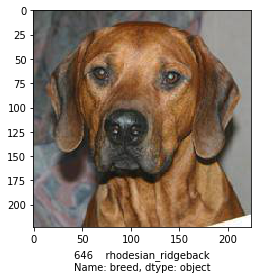

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 19ms/step
The best matches:
breed australian_terrier
	 with accuarcy: 0.2023560106754303
breed rhodesian_ridgeback
	 with accuarcy: 0.14507512748241425
breed african_hunting_dog
	 with accuarcy: 0.038151826709508896
breed vizsla
	 with accuarcy: 0.0370318740606308
breed chesapeake_bay_retriever
	 with accuarcy: 0.03519371896982193


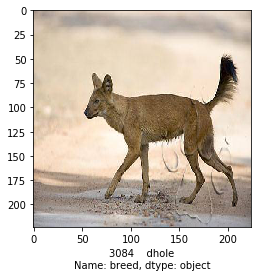

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
The best matches:
breed dandie_dinmont
	 with accuarcy: 0.1093340665102005
breed chesapeake_bay_retriever
	 with accuarcy: 0.10571848601102829
breed african_hunting_dog
	 with accuarcy: 0.09996278584003448
breed old_english_sheepdog
	 with accuarcy: 0.06880597025156021
breed australian_terrier
	 with accuarcy: 0.048721794039011


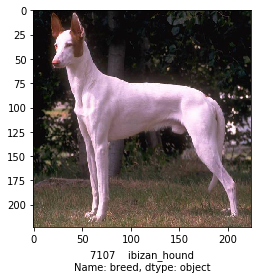

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 14ms/step
The best matches:
breed ibizan_hound
	 with accuarcy: 0.2648770213127136
breed clumber
	 with accuarcy: 0.12381456047296524
breed dandie_dinmont
	 with accuarcy: 0.09889519214630127
breed maltese_dog
	 with accuarcy: 0.0673278421163559
breed shih-tzu
	 with accuarcy: 0.04328293725848198


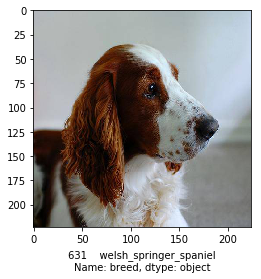

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 14ms/step
The best matches:
breed appenzeller
	 with accuarcy: 0.16898924112319946
breed english_springer
	 with accuarcy: 0.08134234696626663
breed border_collie
	 with accuarcy: 0.06932680308818817
breed german_shepherd
	 with accuarcy: 0.06513529270887375
breed collie
	 with accuarcy: 0.06489231437444687


In [263]:
bestPreds(thirdModel, '0fc1bd3c4d89b3f89dc91605032fa8f9', 5)
bestPreds(thirdModel, '4c2ca9ee822b5ab533a73422fadafec9', 5)
bestPreds(thirdModel, 'b25f133c4dffc6d1eba2ae381ecb6d18', 5)
bestPreds(thirdModel, '0f7c817dd5f8b8d6b57e3b7f3e2f4f56', 5)

This model performed similiarly to the first one with reaching the accuarcy of 35% which is a very good improvement. The accuarcy loss also drops in a pretty steady pace. The third model did correctly clasify the easier breeds like the first model. However, after a quick check we can see that model 3 classified the Rhodesian Ridgeback as an Australian Terrier and model 1 classified the Rhodesian Ridgeback as a Vislza. by checking the breeds ourselves we saw that model 1 was a lot closer than model 3. 

Lets give model 3 a good training and see how it performs. The next training will be for 40 epochs with batch size 50, Hopefully, we will finally achieve good results.

In [264]:
thirdModel.fit(X_train, Y_train,
               epochs=40, validation_data=(X_valid, Y_valid), 
               verbose=1, batch_size=50
              ,callbacks=callbacks_list)

Train on 8688 samples, validate on 1534 samples
Epoch 1/40
8688/8688 [==============================] - ETA: 5:25 - loss: 2.5632 - acc: 0.480 - ETA: 3:07 - loss: 2.7732 - acc: 0.410 - ETA: 2:21 - loss: 2.8063 - acc: 0.386 - ETA: 1:57 - loss: 2.8707 - acc: 0.355 - ETA: 1:43 - loss: 2.7431 - acc: 0.396 - ETA: 1:34 - loss: 2.7305 - acc: 0.410 - ETA: 1:27 - loss: 2.6950 - acc: 0.417 - ETA: 1:22 - loss: 2.6736 - acc: 0.435 - ETA: 1:18 - loss: 2.6239 - acc: 0.451 - ETA: 1:14 - loss: 2.6261 - acc: 0.442 - ETA: 1:12 - loss: 2.5978 - acc: 0.452 - ETA: 1:09 - loss: 2.5621 - acc: 0.456 - ETA: 1:07 - loss: 2.5620 - acc: 0.456 - ETA: 1:05 - loss: 2.5423 - acc: 0.458 - ETA: 1:04 - loss: 2.5365 - acc: 0.464 - ETA: 1:02 - loss: 2.5247 - acc: 0.462 - ETA: 1:01 - loss: 2.5144 - acc: 0.467 - ETA: 1:00 - loss: 2.4947 - acc: 0.471 - ETA: 59s - loss: 2.4816 - acc: 0.475 - ETA: 57s - loss: 2.4720 - acc: 0.47 - ETA: 57s - loss: 2.4759 - acc: 0.47 - ETA: 56s - loss: 2.4733 - acc: 0.47 - ETA: 55s - loss: 2.4535

8688/8688 [==============================] - ETA: 50s - loss: 2.2406 - acc: 0.56 - ETA: 50s - loss: 2.3621 - acc: 0.53 - ETA: 50s - loss: 2.4334 - acc: 0.50 - ETA: 50s - loss: 2.4164 - acc: 0.51 - ETA: 50s - loss: 2.4250 - acc: 0.50 - ETA: 49s - loss: 2.4053 - acc: 0.49 - ETA: 49s - loss: 2.4271 - acc: 0.48 - ETA: 49s - loss: 2.4038 - acc: 0.49 - ETA: 49s - loss: 2.3758 - acc: 0.51 - ETA: 48s - loss: 2.3924 - acc: 0.51 - ETA: 48s - loss: 2.3750 - acc: 0.51 - ETA: 48s - loss: 2.3896 - acc: 0.51 - ETA: 47s - loss: 2.3858 - acc: 0.50 - ETA: 47s - loss: 2.3546 - acc: 0.51 - ETA: 47s - loss: 2.3462 - acc: 0.52 - ETA: 47s - loss: 2.3564 - acc: 0.51 - ETA: 46s - loss: 2.3538 - acc: 0.51 - ETA: 46s - loss: 2.3615 - acc: 0.51 - ETA: 46s - loss: 2.3751 - acc: 0.51 - ETA: 45s - loss: 2.3681 - acc: 0.51 - ETA: 45s - loss: 2.3631 - acc: 0.51 - ETA: 45s - loss: 2.3412 - acc: 0.52 - ETA: 45s - loss: 2.3289 - acc: 0.51 - ETA: 44s - loss: 2.3327 - acc: 0.51 - ETA: 44s - loss: 2.3308 - acc: 0.51 - ETA: 

8688/8688 [==============================] - ETA: 50s - loss: 2.4732 - acc: 0.40 - ETA: 50s - loss: 2.1932 - acc: 0.50 - ETA: 50s - loss: 2.1765 - acc: 0.53 - ETA: 50s - loss: 2.2425 - acc: 0.52 - ETA: 50s - loss: 2.2689 - acc: 0.52 - ETA: 50s - loss: 2.2809 - acc: 0.51 - ETA: 49s - loss: 2.3218 - acc: 0.50 - ETA: 49s - loss: 2.3056 - acc: 0.50 - ETA: 49s - loss: 2.3146 - acc: 0.50 - ETA: 48s - loss: 2.3147 - acc: 0.50 - ETA: 48s - loss: 2.2983 - acc: 0.51 - ETA: 48s - loss: 2.2819 - acc: 0.51 - ETA: 47s - loss: 2.2634 - acc: 0.52 - ETA: 47s - loss: 2.2679 - acc: 0.52 - ETA: 47s - loss: 2.2670 - acc: 0.52 - ETA: 47s - loss: 2.2777 - acc: 0.52 - ETA: 46s - loss: 2.3131 - acc: 0.51 - ETA: 46s - loss: 2.3181 - acc: 0.51 - ETA: 46s - loss: 2.3103 - acc: 0.51 - ETA: 45s - loss: 2.3059 - acc: 0.51 - ETA: 45s - loss: 2.2965 - acc: 0.50 - ETA: 45s - loss: 2.2973 - acc: 0.51 - ETA: 44s - loss: 2.2873 - acc: 0.51 - ETA: 44s - loss: 2.2905 - acc: 0.52 - ETA: 44s - loss: 2.2900 - acc: 0.52 - ETA: 

8688/8688 [==============================] - ETA: 50s - loss: 2.3166 - acc: 0.52 - ETA: 50s - loss: 2.1781 - acc: 0.57 - ETA: 50s - loss: 2.1633 - acc: 0.57 - ETA: 49s - loss: 2.1408 - acc: 0.57 - ETA: 49s - loss: 2.2769 - acc: 0.53 - ETA: 49s - loss: 2.2526 - acc: 0.53 - ETA: 49s - loss: 2.2518 - acc: 0.54 - ETA: 48s - loss: 2.2295 - acc: 0.53 - ETA: 48s - loss: 2.2354 - acc: 0.53 - ETA: 48s - loss: 2.2863 - acc: 0.53 - ETA: 48s - loss: 2.2928 - acc: 0.52 - ETA: 47s - loss: 2.2814 - acc: 0.52 - ETA: 47s - loss: 2.2643 - acc: 0.53 - ETA: 47s - loss: 2.2706 - acc: 0.53 - ETA: 47s - loss: 2.2522 - acc: 0.53 - ETA: 46s - loss: 2.2495 - acc: 0.53 - ETA: 46s - loss: 2.2405 - acc: 0.53 - ETA: 46s - loss: 2.2414 - acc: 0.53 - ETA: 45s - loss: 2.2565 - acc: 0.53 - ETA: 45s - loss: 2.2534 - acc: 0.53 - ETA: 45s - loss: 2.2520 - acc: 0.53 - ETA: 44s - loss: 2.2434 - acc: 0.53 - ETA: 44s - loss: 2.2209 - acc: 0.54 - ETA: 44s - loss: 2.2305 - acc: 0.54 - ETA: 44s - loss: 2.2268 - acc: 0.54 - ETA: 

8688/8688 [==============================] - ETA: 51s - loss: 2.2312 - acc: 0.56 - ETA: 51s - loss: 2.3026 - acc: 0.54 - ETA: 50s - loss: 2.2961 - acc: 0.55 - ETA: 50s - loss: 2.1826 - acc: 0.58 - ETA: 50s - loss: 2.1745 - acc: 0.56 - ETA: 49s - loss: 2.1650 - acc: 0.57 - ETA: 49s - loss: 2.1166 - acc: 0.57 - ETA: 49s - loss: 2.1356 - acc: 0.55 - ETA: 48s - loss: 2.1650 - acc: 0.54 - ETA: 48s - loss: 2.1448 - acc: 0.54 - ETA: 48s - loss: 2.1292 - acc: 0.55 - ETA: 48s - loss: 2.1226 - acc: 0.55 - ETA: 47s - loss: 2.1069 - acc: 0.56 - ETA: 47s - loss: 2.0915 - acc: 0.57 - ETA: 47s - loss: 2.1055 - acc: 0.56 - ETA: 46s - loss: 2.0926 - acc: 0.57 - ETA: 46s - loss: 2.0961 - acc: 0.57 - ETA: 46s - loss: 2.0932 - acc: 0.57 - ETA: 46s - loss: 2.0845 - acc: 0.57 - ETA: 45s - loss: 2.0682 - acc: 0.58 - ETA: 45s - loss: 2.0826 - acc: 0.57 - ETA: 45s - loss: 2.0840 - acc: 0.57 - ETA: 44s - loss: 2.0846 - acc: 0.57 - ETA: 44s - loss: 2.0763 - acc: 0.58 - ETA: 44s - loss: 2.0734 - acc: 0.58 - ETA: 

8688/8688 [==============================] - ETA: 51s - loss: 1.6843 - acc: 0.56 - ETA: 50s - loss: 1.9613 - acc: 0.58 - ETA: 50s - loss: 2.0597 - acc: 0.54 - ETA: 50s - loss: 2.0742 - acc: 0.55 - ETA: 50s - loss: 2.0788 - acc: 0.55 - ETA: 49s - loss: 2.0464 - acc: 0.55 - ETA: 49s - loss: 2.0766 - acc: 0.54 - ETA: 49s - loss: 2.0348 - acc: 0.55 - ETA: 49s - loss: 2.0494 - acc: 0.56 - ETA: 48s - loss: 2.0260 - acc: 0.57 - ETA: 48s - loss: 2.0514 - acc: 0.56 - ETA: 48s - loss: 2.0266 - acc: 0.58 - ETA: 47s - loss: 1.9997 - acc: 0.59 - ETA: 47s - loss: 1.9891 - acc: 0.59 - ETA: 47s - loss: 1.9750 - acc: 0.60 - ETA: 47s - loss: 1.9788 - acc: 0.59 - ETA: 46s - loss: 1.9903 - acc: 0.60 - ETA: 46s - loss: 1.9908 - acc: 0.60 - ETA: 46s - loss: 1.9788 - acc: 0.60 - ETA: 45s - loss: 1.9716 - acc: 0.61 - ETA: 45s - loss: 1.9731 - acc: 0.61 - ETA: 45s - loss: 1.9564 - acc: 0.61 - ETA: 45s - loss: 1.9650 - acc: 0.61 - ETA: 44s - loss: 1.9644 - acc: 0.61 - ETA: 44s - loss: 1.9721 - acc: 0.61 - ETA: 

8688/8688 [==============================] - ETA: 50s - loss: 1.7402 - acc: 0.66 - ETA: 50s - loss: 1.9270 - acc: 0.62 - ETA: 50s - loss: 1.9125 - acc: 0.64 - ETA: 50s - loss: 1.9646 - acc: 0.62 - ETA: 50s - loss: 1.9135 - acc: 0.63 - ETA: 50s - loss: 1.8514 - acc: 0.65 - ETA: 49s - loss: 1.8462 - acc: 0.66 - ETA: 49s - loss: 1.8467 - acc: 0.65 - ETA: 49s - loss: 1.8288 - acc: 0.66 - ETA: 49s - loss: 1.8297 - acc: 0.65 - ETA: 48s - loss: 1.8356 - acc: 0.65 - ETA: 48s - loss: 1.8356 - acc: 0.64 - ETA: 48s - loss: 1.8277 - acc: 0.64 - ETA: 47s - loss: 1.8088 - acc: 0.65 - ETA: 47s - loss: 1.8148 - acc: 0.65 - ETA: 47s - loss: 1.7897 - acc: 0.66 - ETA: 46s - loss: 1.7852 - acc: 0.66 - ETA: 46s - loss: 1.8025 - acc: 0.66 - ETA: 46s - loss: 1.8012 - acc: 0.66 - ETA: 46s - loss: 1.8203 - acc: 0.66 - ETA: 45s - loss: 1.8108 - acc: 0.66 - ETA: 45s - loss: 1.8278 - acc: 0.65 - ETA: 45s - loss: 1.8358 - acc: 0.65 - ETA: 44s - loss: 1.8361 - acc: 0.65 - ETA: 44s - loss: 1.8386 - acc: 0.65 - ETA: 

8688/8688 [==============================] - ETA: 50s - loss: 1.7019 - acc: 0.70 - ETA: 50s - loss: 1.7263 - acc: 0.67 - ETA: 50s - loss: 1.7248 - acc: 0.67 - ETA: 50s - loss: 1.7329 - acc: 0.64 - ETA: 50s - loss: 1.7490 - acc: 0.64 - ETA: 49s - loss: 1.8005 - acc: 0.64 - ETA: 49s - loss: 1.8315 - acc: 0.62 - ETA: 49s - loss: 1.8370 - acc: 0.63 - ETA: 49s - loss: 1.8371 - acc: 0.63 - ETA: 48s - loss: 1.8261 - acc: 0.64 - ETA: 48s - loss: 1.8041 - acc: 0.65 - ETA: 48s - loss: 1.7956 - acc: 0.65 - ETA: 47s - loss: 1.7698 - acc: 0.66 - ETA: 47s - loss: 1.8037 - acc: 0.65 - ETA: 47s - loss: 1.8008 - acc: 0.65 - ETA: 47s - loss: 1.8033 - acc: 0.64 - ETA: 46s - loss: 1.8065 - acc: 0.64 - ETA: 46s - loss: 1.8276 - acc: 0.63 - ETA: 46s - loss: 1.8228 - acc: 0.63 - ETA: 45s - loss: 1.8142 - acc: 0.63 - ETA: 45s - loss: 1.8030 - acc: 0.63 - ETA: 45s - loss: 1.7950 - acc: 0.64 - ETA: 44s - loss: 1.7881 - acc: 0.64 - ETA: 44s - loss: 1.7719 - acc: 0.65 - ETA: 44s - loss: 1.7611 - acc: 0.65 - ETA: 

8688/8688 [==============================] - ETA: 50s - loss: 1.5269 - acc: 0.78 - ETA: 50s - loss: 1.7621 - acc: 0.63 - ETA: 50s - loss: 1.7099 - acc: 0.64 - ETA: 50s - loss: 1.7515 - acc: 0.64 - ETA: 50s - loss: 1.8272 - acc: 0.62 - ETA: 50s - loss: 1.8510 - acc: 0.61 - ETA: 49s - loss: 1.8285 - acc: 0.61 - ETA: 49s - loss: 1.7993 - acc: 0.62 - ETA: 49s - loss: 1.7979 - acc: 0.63 - ETA: 48s - loss: 1.7537 - acc: 0.65 - ETA: 48s - loss: 1.7173 - acc: 0.66 - ETA: 48s - loss: 1.7133 - acc: 0.67 - ETA: 47s - loss: 1.7408 - acc: 0.65 - ETA: 47s - loss: 1.7491 - acc: 0.65 - ETA: 47s - loss: 1.7540 - acc: 0.66 - ETA: 47s - loss: 1.7528 - acc: 0.66 - ETA: 46s - loss: 1.7434 - acc: 0.66 - ETA: 46s - loss: 1.7552 - acc: 0.66 - ETA: 46s - loss: 1.7711 - acc: 0.65 - ETA: 45s - loss: 1.7720 - acc: 0.65 - ETA: 45s - loss: 1.7670 - acc: 0.65 - ETA: 45s - loss: 1.7742 - acc: 0.65 - ETA: 44s - loss: 1.7771 - acc: 0.64 - ETA: 44s - loss: 1.7687 - acc: 0.65 - ETA: 44s - loss: 1.7660 - acc: 0.65 - ETA: 

8688/8688 [==============================] - ETA: 50s - loss: 1.3689 - acc: 0.70 - ETA: 50s - loss: 1.5756 - acc: 0.69 - ETA: 50s - loss: 1.7221 - acc: 0.65 - ETA: 50s - loss: 1.6357 - acc: 0.69 - ETA: 50s - loss: 1.6103 - acc: 0.70 - ETA: 49s - loss: 1.5999 - acc: 0.70 - ETA: 49s - loss: 1.6202 - acc: 0.69 - ETA: 49s - loss: 1.6331 - acc: 0.69 - ETA: 48s - loss: 1.6377 - acc: 0.68 - ETA: 48s - loss: 1.6299 - acc: 0.69 - ETA: 48s - loss: 1.6140 - acc: 0.69 - ETA: 47s - loss: 1.6001 - acc: 0.70 - ETA: 47s - loss: 1.6175 - acc: 0.69 - ETA: 47s - loss: 1.6078 - acc: 0.70 - ETA: 47s - loss: 1.6177 - acc: 0.69 - ETA: 46s - loss: 1.6171 - acc: 0.70 - ETA: 46s - loss: 1.6301 - acc: 0.70 - ETA: 46s - loss: 1.6438 - acc: 0.70 - ETA: 45s - loss: 1.6270 - acc: 0.71 - ETA: 45s - loss: 1.6331 - acc: 0.70 - ETA: 45s - loss: 1.6197 - acc: 0.70 - ETA: 45s - loss: 1.6123 - acc: 0.70 - ETA: 44s - loss: 1.6252 - acc: 0.70 - ETA: 44s - loss: 1.6145 - acc: 0.70 - ETA: 44s - loss: 1.6208 - acc: 0.70 - ETA: 

8688/8688 [==============================] - ETA: 50s - loss: 1.4105 - acc: 0.78 - ETA: 50s - loss: 1.3284 - acc: 0.79 - ETA: 50s - loss: 1.3508 - acc: 0.78 - ETA: 50s - loss: 1.3746 - acc: 0.79 - ETA: 49s - loss: 1.4214 - acc: 0.78 - ETA: 49s - loss: 1.4417 - acc: 0.77 - ETA: 49s - loss: 1.4288 - acc: 0.77 - ETA: 49s - loss: 1.4394 - acc: 0.75 - ETA: 48s - loss: 1.3878 - acc: 0.77 - ETA: 48s - loss: 1.4366 - acc: 0.75 - ETA: 48s - loss: 1.4367 - acc: 0.76 - ETA: 47s - loss: 1.4675 - acc: 0.75 - ETA: 47s - loss: 1.4550 - acc: 0.75 - ETA: 47s - loss: 1.4644 - acc: 0.75 - ETA: 47s - loss: 1.4735 - acc: 0.74 - ETA: 46s - loss: 1.4524 - acc: 0.75 - ETA: 46s - loss: 1.4575 - acc: 0.75 - ETA: 46s - loss: 1.4533 - acc: 0.75 - ETA: 45s - loss: 1.4653 - acc: 0.75 - ETA: 45s - loss: 1.4810 - acc: 0.74 - ETA: 45s - loss: 1.4776 - acc: 0.75 - ETA: 44s - loss: 1.4807 - acc: 0.74 - ETA: 44s - loss: 1.4701 - acc: 0.74 - ETA: 44s - loss: 1.4699 - acc: 0.74 - ETA: 44s - loss: 1.4669 - acc: 0.74 - ETA: 

8688/8688 [==============================] - ETA: 51s - loss: 1.5151 - acc: 0.76 - ETA: 50s - loss: 1.6071 - acc: 0.73 - ETA: 50s - loss: 1.5195 - acc: 0.74 - ETA: 50s - loss: 1.4974 - acc: 0.72 - ETA: 49s - loss: 1.4770 - acc: 0.72 - ETA: 49s - loss: 1.4445 - acc: 0.73 - ETA: 49s - loss: 1.4278 - acc: 0.73 - ETA: 49s - loss: 1.4179 - acc: 0.74 - ETA: 48s - loss: 1.3945 - acc: 0.74 - ETA: 48s - loss: 1.3948 - acc: 0.75 - ETA: 48s - loss: 1.3829 - acc: 0.76 - ETA: 47s - loss: 1.3685 - acc: 0.76 - ETA: 47s - loss: 1.3723 - acc: 0.76 - ETA: 47s - loss: 1.3999 - acc: 0.75 - ETA: 47s - loss: 1.4012 - acc: 0.75 - ETA: 46s - loss: 1.3923 - acc: 0.76 - ETA: 46s - loss: 1.3913 - acc: 0.76 - ETA: 46s - loss: 1.3899 - acc: 0.76 - ETA: 46s - loss: 1.3956 - acc: 0.76 - ETA: 45s - loss: 1.3950 - acc: 0.76 - ETA: 45s - loss: 1.3961 - acc: 0.76 - ETA: 45s - loss: 1.3934 - acc: 0.76 - ETA: 44s - loss: 1.3934 - acc: 0.76 - ETA: 44s - loss: 1.4015 - acc: 0.76 - ETA: 44s - loss: 1.3922 - acc: 0.76 - ETA: 

8688/8688 [==============================] - ETA: 51s - loss: 1.3930 - acc: 0.72 - ETA: 50s - loss: 1.3619 - acc: 0.75 - ETA: 50s - loss: 1.3829 - acc: 0.75 - ETA: 50s - loss: 1.3354 - acc: 0.77 - ETA: 49s - loss: 1.3587 - acc: 0.77 - ETA: 49s - loss: 1.3858 - acc: 0.76 - ETA: 49s - loss: 1.3720 - acc: 0.76 - ETA: 48s - loss: 1.3448 - acc: 0.77 - ETA: 48s - loss: 1.3529 - acc: 0.77 - ETA: 48s - loss: 1.3362 - acc: 0.77 - ETA: 48s - loss: 1.3407 - acc: 0.77 - ETA: 47s - loss: 1.3162 - acc: 0.78 - ETA: 47s - loss: 1.3291 - acc: 0.78 - ETA: 47s - loss: 1.3199 - acc: 0.78 - ETA: 46s - loss: 1.3122 - acc: 0.78 - ETA: 46s - loss: 1.3130 - acc: 0.78 - ETA: 46s - loss: 1.3039 - acc: 0.78 - ETA: 46s - loss: 1.2947 - acc: 0.78 - ETA: 45s - loss: 1.3008 - acc: 0.78 - ETA: 45s - loss: 1.2883 - acc: 0.78 - ETA: 45s - loss: 1.2947 - acc: 0.78 - ETA: 44s - loss: 1.2992 - acc: 0.78 - ETA: 44s - loss: 1.3103 - acc: 0.77 - ETA: 44s - loss: 1.3117 - acc: 0.77 - ETA: 43s - loss: 1.3163 - acc: 0.77 - ETA: 

8688/8688 [==============================] - ETA: 51s - loss: 1.3902 - acc: 0.74 - ETA: 50s - loss: 1.3934 - acc: 0.74 - ETA: 50s - loss: 1.3628 - acc: 0.74 - ETA: 50s - loss: 1.4651 - acc: 0.73 - ETA: 50s - loss: 1.4395 - acc: 0.73 - ETA: 49s - loss: 1.4543 - acc: 0.73 - ETA: 49s - loss: 1.4118 - acc: 0.74 - ETA: 49s - loss: 1.4342 - acc: 0.73 - ETA: 48s - loss: 1.4272 - acc: 0.73 - ETA: 48s - loss: 1.4307 - acc: 0.73 - ETA: 48s - loss: 1.4137 - acc: 0.74 - ETA: 47s - loss: 1.3888 - acc: 0.75 - ETA: 47s - loss: 1.3972 - acc: 0.74 - ETA: 47s - loss: 1.3992 - acc: 0.75 - ETA: 47s - loss: 1.4071 - acc: 0.74 - ETA: 46s - loss: 1.4079 - acc: 0.74 - ETA: 46s - loss: 1.4019 - acc: 0.74 - ETA: 46s - loss: 1.3863 - acc: 0.75 - ETA: 45s - loss: 1.3990 - acc: 0.74 - ETA: 45s - loss: 1.3838 - acc: 0.75 - ETA: 45s - loss: 1.3939 - acc: 0.74 - ETA: 44s - loss: 1.3958 - acc: 0.74 - ETA: 44s - loss: 1.3865 - acc: 0.75 - ETA: 44s - loss: 1.3825 - acc: 0.75 - ETA: 44s - loss: 1.3706 - acc: 0.75 - ETA: 

8688/8688 [==============================] - ETA: 51s - loss: 1.0854 - acc: 0.80 - ETA: 51s - loss: 1.3918 - acc: 0.75 - ETA: 51s - loss: 1.2688 - acc: 0.80 - ETA: 51s - loss: 1.2456 - acc: 0.80 - ETA: 50s - loss: 1.2433 - acc: 0.80 - ETA: 50s - loss: 1.2242 - acc: 0.80 - ETA: 50s - loss: 1.2489 - acc: 0.79 - ETA: 49s - loss: 1.2468 - acc: 0.79 - ETA: 49s - loss: 1.2017 - acc: 0.80 - ETA: 49s - loss: 1.1881 - acc: 0.81 - ETA: 49s - loss: 1.1911 - acc: 0.80 - ETA: 48s - loss: 1.1962 - acc: 0.80 - ETA: 48s - loss: 1.2053 - acc: 0.79 - ETA: 48s - loss: 1.1994 - acc: 0.80 - ETA: 47s - loss: 1.1867 - acc: 0.80 - ETA: 47s - loss: 1.2021 - acc: 0.80 - ETA: 47s - loss: 1.2178 - acc: 0.79 - ETA: 46s - loss: 1.2228 - acc: 0.79 - ETA: 46s - loss: 1.2307 - acc: 0.79 - ETA: 46s - loss: 1.2270 - acc: 0.79 - ETA: 46s - loss: 1.2254 - acc: 0.79 - ETA: 45s - loss: 1.2232 - acc: 0.79 - ETA: 45s - loss: 1.2257 - acc: 0.79 - ETA: 45s - loss: 1.2205 - acc: 0.79 - ETA: 44s - loss: 1.2169 - acc: 0.79 - ETA: 

8688/8688 [==============================] - ETA: 50s - loss: 1.0661 - acc: 0.90 - ETA: 50s - loss: 1.0403 - acc: 0.89 - ETA: 50s - loss: 1.0179 - acc: 0.89 - ETA: 49s - loss: 1.0441 - acc: 0.87 - ETA: 50s - loss: 1.0707 - acc: 0.86 - ETA: 50s - loss: 1.0661 - acc: 0.84 - ETA: 49s - loss: 1.0817 - acc: 0.84 - ETA: 49s - loss: 1.0931 - acc: 0.83 - ETA: 49s - loss: 1.1013 - acc: 0.83 - ETA: 48s - loss: 1.1149 - acc: 0.83 - ETA: 48s - loss: 1.1364 - acc: 0.83 - ETA: 48s - loss: 1.1484 - acc: 0.82 - ETA: 47s - loss: 1.1350 - acc: 0.83 - ETA: 47s - loss: 1.1392 - acc: 0.83 - ETA: 47s - loss: 1.1244 - acc: 0.83 - ETA: 46s - loss: 1.1386 - acc: 0.83 - ETA: 46s - loss: 1.1411 - acc: 0.82 - ETA: 46s - loss: 1.1431 - acc: 0.82 - ETA: 46s - loss: 1.1430 - acc: 0.82 - ETA: 45s - loss: 1.1342 - acc: 0.82 - ETA: 45s - loss: 1.1292 - acc: 0.82 - ETA: 45s - loss: 1.1230 - acc: 0.83 - ETA: 44s - loss: 1.1271 - acc: 0.82 - ETA: 44s - loss: 1.1209 - acc: 0.82 - ETA: 44s - loss: 1.1249 - acc: 0.82 - ETA: 

8688/8688 [==============================] - ETA: 50s - loss: 0.8872 - acc: 0.92 - ETA: 50s - loss: 0.8659 - acc: 0.94 - ETA: 50s - loss: 0.9226 - acc: 0.89 - ETA: 49s - loss: 0.9710 - acc: 0.87 - ETA: 49s - loss: 0.9954 - acc: 0.86 - ETA: 49s - loss: 1.0156 - acc: 0.85 - ETA: 49s - loss: 1.0243 - acc: 0.84 - ETA: 49s - loss: 1.0274 - acc: 0.84 - ETA: 48s - loss: 1.0160 - acc: 0.84 - ETA: 48s - loss: 1.0406 - acc: 0.83 - ETA: 48s - loss: 1.0274 - acc: 0.84 - ETA: 47s - loss: 1.0103 - acc: 0.84 - ETA: 47s - loss: 1.0439 - acc: 0.84 - ETA: 47s - loss: 1.0475 - acc: 0.84 - ETA: 47s - loss: 1.0433 - acc: 0.84 - ETA: 46s - loss: 1.0508 - acc: 0.84 - ETA: 46s - loss: 1.0639 - acc: 0.83 - ETA: 46s - loss: 1.0584 - acc: 0.83 - ETA: 46s - loss: 1.0532 - acc: 0.83 - ETA: 45s - loss: 1.0543 - acc: 0.83 - ETA: 45s - loss: 1.0632 - acc: 0.82 - ETA: 45s - loss: 1.0634 - acc: 0.82 - ETA: 44s - loss: 1.0502 - acc: 0.83 - ETA: 44s - loss: 1.0615 - acc: 0.83 - ETA: 44s - loss: 1.0635 - acc: 0.82 - ETA: 

8688/8688 [==============================] - ETA: 54s - loss: 1.1705 - acc: 0.86 - ETA: 56s - loss: 0.9679 - acc: 0.89 - ETA: 54s - loss: 1.0653 - acc: 0.83 - ETA: 53s - loss: 1.0651 - acc: 0.84 - ETA: 52s - loss: 1.0277 - acc: 0.86 - ETA: 51s - loss: 1.0226 - acc: 0.85 - ETA: 51s - loss: 1.0861 - acc: 0.82 - ETA: 50s - loss: 1.0795 - acc: 0.81 - ETA: 50s - loss: 1.0652 - acc: 0.82 - ETA: 50s - loss: 1.0539 - acc: 0.82 - ETA: 49s - loss: 1.0614 - acc: 0.82 - ETA: 49s - loss: 1.0577 - acc: 0.83 - ETA: 49s - loss: 1.0506 - acc: 0.83 - ETA: 48s - loss: 1.0429 - acc: 0.83 - ETA: 48s - loss: 1.0425 - acc: 0.84 - ETA: 48s - loss: 1.0450 - acc: 0.83 - ETA: 48s - loss: 1.0480 - acc: 0.83 - ETA: 47s - loss: 1.0417 - acc: 0.84 - ETA: 47s - loss: 1.0499 - acc: 0.84 - ETA: 47s - loss: 1.0445 - acc: 0.84 - ETA: 46s - loss: 1.0372 - acc: 0.84 - ETA: 46s - loss: 1.0224 - acc: 0.85 - ETA: 46s - loss: 1.0187 - acc: 0.85 - ETA: 46s - loss: 1.0154 - acc: 0.85 - ETA: 45s - loss: 1.0086 - acc: 0.85 - ETA: 

8688/8688 [==============================] - ETA: 50s - loss: 0.7889 - acc: 0.88 - ETA: 50s - loss: 0.8921 - acc: 0.86 - ETA: 50s - loss: 0.9779 - acc: 0.85 - ETA: 50s - loss: 0.9705 - acc: 0.86 - ETA: 49s - loss: 0.9685 - acc: 0.86 - ETA: 49s - loss: 0.9774 - acc: 0.85 - ETA: 49s - loss: 0.9586 - acc: 0.86 - ETA: 49s - loss: 0.9800 - acc: 0.85 - ETA: 48s - loss: 0.9567 - acc: 0.86 - ETA: 48s - loss: 0.9848 - acc: 0.85 - ETA: 48s - loss: 0.9854 - acc: 0.85 - ETA: 47s - loss: 0.9856 - acc: 0.86 - ETA: 47s - loss: 0.9861 - acc: 0.86 - ETA: 47s - loss: 0.9871 - acc: 0.86 - ETA: 47s - loss: 0.9925 - acc: 0.85 - ETA: 46s - loss: 0.9764 - acc: 0.86 - ETA: 46s - loss: 0.9743 - acc: 0.86 - ETA: 46s - loss: 0.9653 - acc: 0.86 - ETA: 46s - loss: 0.9588 - acc: 0.86 - ETA: 45s - loss: 0.9481 - acc: 0.87 - ETA: 45s - loss: 0.9443 - acc: 0.87 - ETA: 45s - loss: 0.9379 - acc: 0.87 - ETA: 44s - loss: 0.9414 - acc: 0.87 - ETA: 44s - loss: 0.9417 - acc: 0.87 - ETA: 44s - loss: 0.9514 - acc: 0.87 - ETA: 

8688/8688 [==============================] - ETA: 50s - loss: 1.1185 - acc: 0.84 - ETA: 50s - loss: 1.1581 - acc: 0.80 - ETA: 49s - loss: 1.0727 - acc: 0.82 - ETA: 49s - loss: 1.0008 - acc: 0.84 - ETA: 49s - loss: 0.9920 - acc: 0.83 - ETA: 49s - loss: 0.9966 - acc: 0.83 - ETA: 49s - loss: 1.0564 - acc: 0.82 - ETA: 49s - loss: 1.0428 - acc: 0.82 - ETA: 48s - loss: 1.0123 - acc: 0.83 - ETA: 48s - loss: 0.9981 - acc: 0.84 - ETA: 48s - loss: 0.9893 - acc: 0.85 - ETA: 47s - loss: 0.9746 - acc: 0.85 - ETA: 47s - loss: 0.9743 - acc: 0.85 - ETA: 47s - loss: 0.9777 - acc: 0.85 - ETA: 47s - loss: 0.9667 - acc: 0.85 - ETA: 46s - loss: 0.9582 - acc: 0.85 - ETA: 46s - loss: 0.9521 - acc: 0.85 - ETA: 46s - loss: 0.9391 - acc: 0.86 - ETA: 45s - loss: 0.9374 - acc: 0.86 - ETA: 45s - loss: 0.9474 - acc: 0.86 - ETA: 45s - loss: 0.9565 - acc: 0.86 - ETA: 44s - loss: 0.9554 - acc: 0.86 - ETA: 44s - loss: 0.9498 - acc: 0.86 - ETA: 44s - loss: 0.9442 - acc: 0.86 - ETA: 44s - loss: 0.9411 - acc: 0.86 - ETA: 

After the long training run, the model achieved the accuarcy of 94% with accuarcy loss of 0.87, which is the lowest we got so far. Lets see how well the model performs in tests.

In [265]:
preds = thirdModel.predict(x_test_raw, verbose=1)

10357/10357 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 56 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ET

In [268]:
sub = pd.DataFrame(preds)
col_names = one_hot.columns.values
sub.columns = col_names
sub.insert(0, 'id', df_test['id'])
sub.head(20)

id  affenpinscher  afghan_hound  \
0   000621fb3cbb32d8935728e48679680e       0.000039      0.003198   
1   00102ee9d8eb90812350685311fe5890       0.000007      0.000171   
2   0012a730dfa437f5f3613fb75efcd4ce       0.000158      0.015246   
3   001510bc8570bbeee98c8d80c8a95ec1       0.000048      0.000645   
4   001a5f3114548acdefa3d4da05474c2e       0.000091      0.006440   
5   00225dcd3e4d2410dd53239f95c0352f       0.000586      0.017603   
6   002c2a3117c2193b4d26400ce431eebd       0.000203      0.009799   
7   002c58d413a521ae8d1a5daeb35fc803       0.000009      0.000192   
8   002f80396f1e3db687c5932d7978b196       0.000108      0.003846   
9   0036c6bcec6031be9e62a257b1c3c442       0.000052      0.000453   
10  0041940322116ae58c38130f5a6f71f9       0.000858      0.001141   
11  0042d6bf3e5f3700865886db32689436       0.000016      0.012755   
12  004476c96f575879af4af471af65cae8       0.001603      0.001292   
13  00485d47de966a9437ad3b33ac193b6f       0.000008      0.016687   
14  00496f65de6cc319145ce97bd6e90360       0.001464      0.000591   
15  004bf14426d1a830d459a9e0c0721309       0.000550      0.002582   
16  004c3721eb88358f462cdcec6b2380b7       0.000888      0.007034   
17  00559f56aab7e0a7749220f6aed65162       0.000018      0.074966   
18  005b281f1a4d6f29d527c9585e9bd33c       0.000085      0.006244   
19  005b6c6c76fefd6b458ef6fb6e54da6e       0.000746      0.008349   

    african_hunting_dog  airedale  american_staffordshire_terrier  \
0              0.000996  0.013984                        0.000592   
1              0.000062  0.000866                        0.000034   
2              0.000310  0.015485                        0.008931   
3              0.002646  0.009141                        0.000499   
4              0.000013  0.004612                        0.006545   
5              0.001478  0.005793                        0.003816   
6              0.070175  0.038180                        0.000241   
7              0.000042  0.001054                        0.000181   
8              0.028229  0.037177                        0.006804   
9              0.000379  0.115626                        0.001891   
10             0.002698  0.027743                        0.000222   
11             0.000018  0.000909                        0.000017   
12             0.000138  0.007662                        0.044849   
13             0.006861  0.005133                        0.000642   
14             0.009313  0.011193                        0.002483   
15             0.089177  0.020173                        0.001212   
16             0.072623  0.045009                        0.001736   
17             0.001317  0.001087                        0.000931   
18             0.015705  0.022337                        0.004138   
19             0.006160  0.005606                        0.002292   

    appenzeller  australian_terrier   basenji    basset        ...          \
0      0.000806            0.000079  0.003298  0.001244        ...           
1      0.000001            0.000478  0.000239  0.018425        ...           
2      0.001331            0.000938  0.016266  0.009840        ...           
3      0.002938            0.000853  0.005995  0.053409        ...           
4      0.001070            0.000080  0.000109  0.007348        ...           
5      0.002443            0.011750  0.009801  0.006934        ...           
6      0.011136            0.001906  0.005739  0.007596        ...           
7      0.000002            0.000126  0.000150  0.000205        ...           
8      0.000790            0.000228  0.003430  0.005110        ...           
9      0.000107            0.002928  0.002867  0.040133        ...           
10     0.000175            0.013075  0.001033  0.001075        ...           
11     0.000002            0.000031  0.009464  0.002860        ...           
12     0.003105            0.000085  0.002490  0.005709        ...           
13     0.006851            0.000099  0.008

We can see that the model now is very precise in its classification. On correct classifications the model gives a very large value to the correct class, unlike the other classes that have a very low value. Lets see the performance on the special test batch.

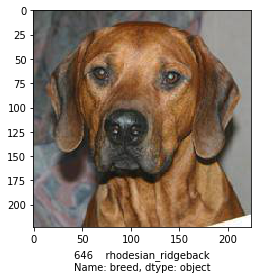

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
The best matches:
breed rhodesian_ridgeback
	 with accuarcy: 0.1544417440891266
breed irish_terrier
	 with accuarcy: 0.11941274255514145
breed norfolk_terrier
	 with accuarcy: 0.08157356828451157
breed chow
	 with accuarcy: 0.04358518123626709
breed boxer
	 with accuarcy: 0.03958139196038246


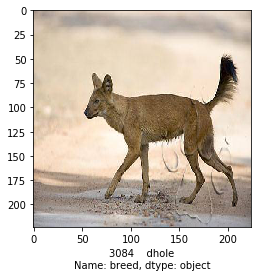

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 13ms/step
The best matches:
breed dhole
	 with accuarcy: 0.6969848871231079
breed dingo
	 with accuarcy: 0.034428782761096954
breed african_hunting_dog
	 with accuarcy: 0.023866359144449234
breed scottish_deerhound
	 with accuarcy: 0.02151206135749817
breed pug
	 with accuarcy: 0.020840493962168694


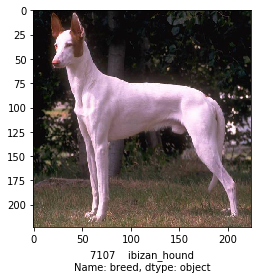

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
The best matches:
breed ibizan_hound
	 with accuarcy: 0.9856077432632446
breed clumber
	 with accuarcy: 0.006554895546287298
breed great_pyrenees
	 with accuarcy: 0.0023344478104263544
breed shih-tzu
	 with accuarcy: 0.0008905334980227053
breed kuvasz
	 with accuarcy: 0.0007279365672729909


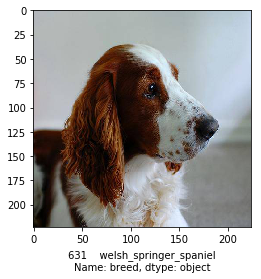

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 14ms/step
The best matches:
breed welsh_springer_spaniel
	 with accuarcy: 0.5059346556663513
breed border_collie
	 with accuarcy: 0.06663482636213303
breed appenzeller
	 with accuarcy: 0.05127740278840065
breed collie
	 with accuarcy: 0.027184942737221718
breed irish_setter
	 with accuarcy: 0.02483448013663292


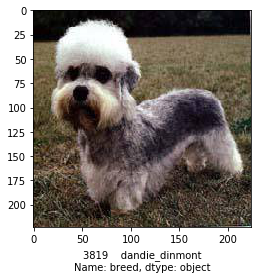

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
The best matches:
breed dandie_dinmont
	 with accuarcy: 0.7324209213256836
breed english_setter
	 with accuarcy: 0.07283326983451843
breed basset
	 with accuarcy: 0.011502972804009914
breed french_bulldog
	 with accuarcy: 0.010643583722412586
breed clumber
	 with accuarcy: 0.010351277887821198


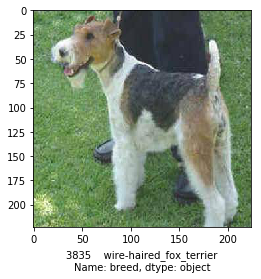

input shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
The best matches:
breed wire-haired_fox_terrier
	 with accuarcy: 0.6036850214004517
breed great_pyrenees
	 with accuarcy: 0.060058798640966415
breed english_foxhound
	 with accuarcy: 0.02667478285729885
breed blenheim_spaniel
	 with accuarcy: 0.025538131594657898
breed clumber
	 with accuarcy: 0.025461236014962196


In [270]:
bestPreds(thirdModel, '0fc1bd3c4d89b3f89dc91605032fa8f9', 5)
bestPreds(thirdModel, '4c2ca9ee822b5ab533a73422fadafec9', 5)
bestPreds(thirdModel, 'b25f133c4dffc6d1eba2ae381ecb6d18', 5)
bestPreds(thirdModel, '0f7c817dd5f8b8d6b57e3b7f3e2f4f56', 5)
bestPreds(thirdModel, '5e7b3a1feb461dcd22e3342f58961c67', 5)
bestPreds(thirdModel, '5f11c3406c4778ed1f2284c6817fe9aa', 5)

YES! The model was correct in all the classifications of the choosen samples. We can see its performance on each class differs. Some were very easy to distinguish like the Dandie Dinmont and the Ibizan Hound, we can see the difference in the values of the correct class besides the next best predictions. In other case of the Rhodesian Ridgeback, the model was pretty close in the results with the next best predictions and had the value only at 0.15, but it was the highest value and finally the we were able to correctly identify the breed of the Rhodesian Ridgeback.

## ML Training


The classic ML algorithm we chose is SVM. First of all we will extract the last layer of the third model and use it as features for our ML model. 

In [271]:

from keras import backend as K
for l in range(len(thirdModel.layers)):
    print(l, thirdModel.layers[l])

0 <keras.engine.input_layer.InputLayer object at 0x00000255160CDE80>
1 <keras.layers.convolutional.Conv2D object at 0x00000255160C4C88>
2 <keras.layers.convolutional.Conv2D object at 0x00000255160ABB00>
3 <keras.layers.pooling.MaxPooling2D object at 0x0000025515F71240>
4 <keras.layers.convolutional.Conv2D object at 0x0000025516095208>
5 <keras.layers.convolutional.Conv2D object at 0x00000255160FA8D0>
6 <keras.layers.pooling.MaxPooling2D object at 0x0000025516106390>
7 <keras.layers.convolutional.Conv2D object at 0x0000025516106278>
8 <keras.layers.convolutional.Conv2D object at 0x000002551611FF28>
9 <keras.layers.convolutional.Conv2D object at 0x000002551612B9E8>
10 <keras.layers.convolutional.Conv2D object at 0x0000025516144F98>
11 <keras.layers.pooling.MaxPooling2D object at 0x000002551614E7F0>
12 <keras.layers.convolutional.Conv2D object at 0x000002551615AA58>
13 <keras.layers.convolutional.Conv2D object at 0x0000025516172CC0>
14 <keras.layers.convolutional.Conv2D object at 0x000002

In [319]:
features = K.function([thirdModel.layers[0].input, K.learning_phase()],
                        [thirdModel.layers[22].output])


In [351]:
ml_x_train = features([X_train[:80], 0])[0]
ml_x_test = features([X_valid[:50], 0])[0]
ml_y_train = Y_train[:80]
ml_y_train = np.asarray([cell[0] for cell in ml_y_train])
print(ml_x_train.shape,ml_x_test.shape, ml_y_train.shape,)


(80, 25088) (50, 25088) (80,)


In [352]:
def MLbestPreds(model, imgstr, top):
    example = df_train[df_train['id'] == imgstr]
    im = PIL.Image.open('../input/train/{0}'.format(imgstr) + '.jpg').resize((224,224))
    im = np.array(im)
    plt.imshow(im)
    plt.xlabel(example.breed)
    plt.show()
    #im = np.expand_dims(im, axis=0)
    print('input shape: {0}'.format(im.shape))
    print(features(im.tolist()))
    result = model.predict(features(im.tolist()))
    sortedres = (-result).argsort()[0][:top]
    print('The best matches:')
    for index in sortedres:
        print('breed {0}'.format(one_hot.columns[index]))
        print('\t with accuarcy: {0}'.format(result[0][index]))

In [354]:
from sklearn.svm import SVC

mlModel = SVC(gamma='auto').fit(ml_x_train, ml_y_train) 
mlpreds = mlModel.predict(ml_x_test)
print(mlpreds)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]



we tried to fit SVM with the small batch. The module failed to get significant results, probably due to a small batch of samples. SVM is also more likely to struggle with datasets where the number of features is much larger than the number of observations. So most likely our module would not hanlde it well as the dataset was not large and diverse enough to properly train the module.

## Question 4: Summary




The dataset we chose to work with is the Dog Breed Identification datasets. The dataset includes 120 dog breeds and about 20000 samples. The dataset is partly balanced as the range of samples per breed is 60-120. Each sample had to be resized in order to fit for processing.

The model we chose was VGG19 with changing the last layer of the network to dense and flatten correspond to the task at hand. We defined the model to run for 15 epochs in total with different batch sizes. Large batch sizes seem to improve the performance of the model. At first, The model yield considerebly pretty bad results with accuarcy of about 2.5% but with the improvements we got better results but still there was room for improvement. The model bettered to 28% acc and was able to identify some breeds correctly.

We further wanted to improve the model by changing the optimizer to Adam instead of SGD. To get real results we also had to freeze the layers and make them untrainable, this probably is because of the initialization of the weights he had in the beginning of the whole experimatation with the models. After the fix the model was pretty capable of making classifications with the accuarcy of about 35%, not much but still an improvement. 

After giving it a good long run of 40 more epochs and a large batch size, we reached an amazing 94% accuarcy with model number 3, which could finaly predict alot better and handled the special dog test batch with very good results, alot better compared to the previous models

To see how the model compares with different approaches, we use the predictions of the last lair as features with the SVM machine learning algorithm. we took out the last layers - layer 22: flatten ant took its outputs as features for the SVM algorithm. The ML module failed to get significant results, probably due to a small batch of samples.